In [237]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from xgboost import XGBClassifier
from xgboost import plot_importance
from scipy.stats import uniform, truncnorm, randint
os.chdir("C:/Users/peter/Documents/GitHub/Evergreen")
pd.options.display.max_columns = None

In [2]:
raw_trn = pd.read_csv("train.tsv",sep = '\t')
raw_tst = pd.read_csv("test.tsv",sep = '\t')

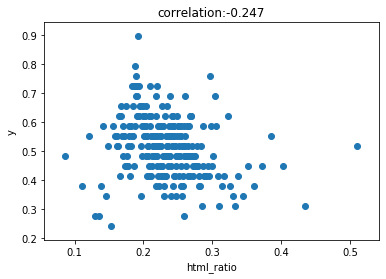

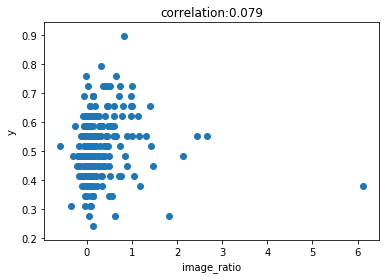

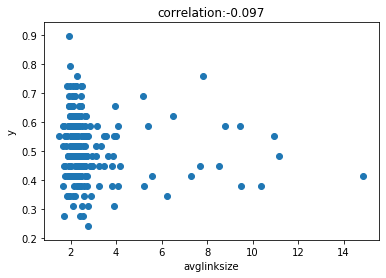

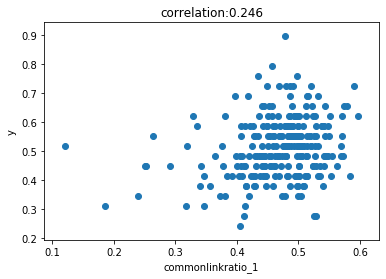

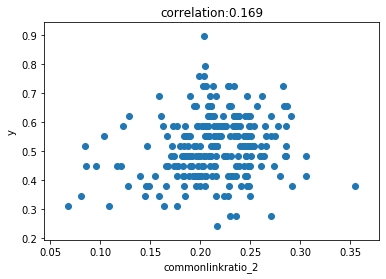

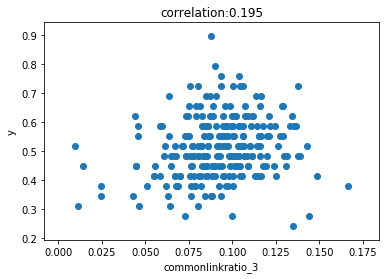

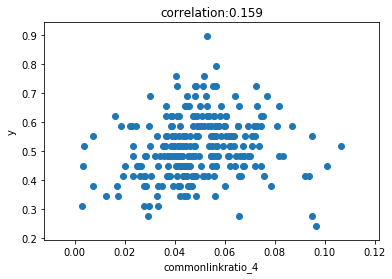

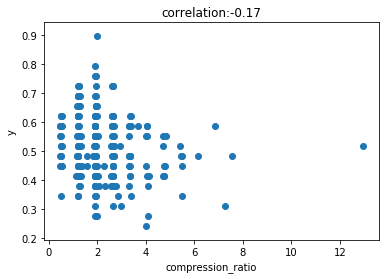

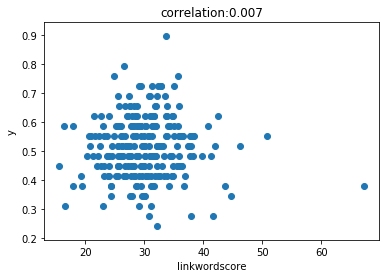

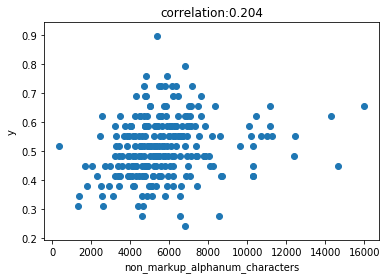

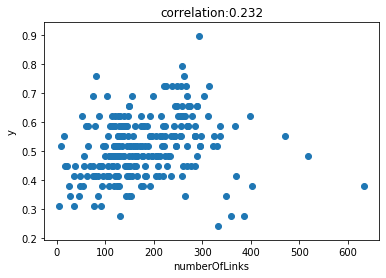

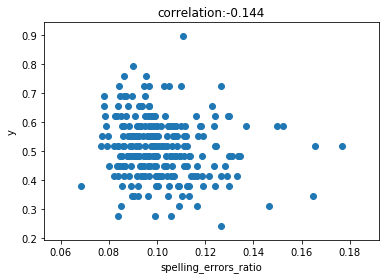

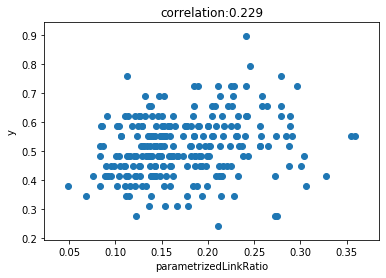

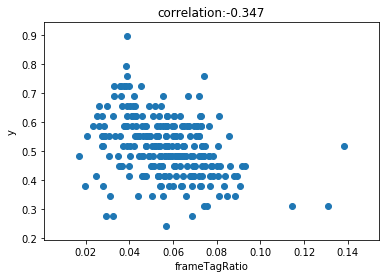

In [3]:
#### Bivariates - Numeric Variables ####
def plot_bivariate(variable):  
    sort_dat = raw_trn.sort_values('html_ratio')
    bkt = pd.Series(range(0,255)).repeat(29)
    sort_dat['bkt']=bkt.tolist()
    sort_dat_groupby_bkt= sort_dat.groupby('bkt')
    corr = np.corrcoef(sort_dat_groupby_bkt[variable].mean(),sort_dat_groupby_bkt['label'].mean())[0][1]
    fig,axs = plt.subplots()
    axs.scatter(sort_dat_groupby_bkt[variable].mean(),sort_dat_groupby_bkt['label'].mean())
    axs.set_xlabel(variable)
    axs.set_ylabel('y')
    axs.set_title("correlation:" + round(corr,3).astype(str) )

plot_bivariate('html_ratio')
plot_bivariate('image_ratio')
plot_bivariate('avglinksize')
plot_bivariate('commonlinkratio_1')
plot_bivariate('commonlinkratio_2')
plot_bivariate('commonlinkratio_3')
plot_bivariate('commonlinkratio_4')
plot_bivariate('compression_ratio')
plot_bivariate('linkwordscore')
plot_bivariate('non_markup_alphanum_characters')
plot_bivariate('numberOfLinks')
plot_bivariate('spelling_errors_ratio')
plot_bivariate('parametrizedLinkRatio')
plot_bivariate('frameTagRatio')




In [4]:
#### Contingency Tables for Categorical Variables ####
print(pd.crosstab(raw_trn.label, raw_trn.is_news))
print(pd.crosstab(raw_trn.label, raw_trn.lengthyLinkDomain))
print(pd.crosstab(raw_trn.label, raw_trn.news_front_page))
print(pd.crosstab(raw_trn.label, raw_trn.alchemy_category))

is_news     1     ?
label              
0        2199  1400
1        2353  1443
lengthyLinkDomain     0     1
label                        
0                  1280  2319
1                  1232  2564
news_front_page     0    1    ?
label                          
0                2814  156  629
1                3039  138  619
alchemy_category     ?  arts_entertainment  business  computer_internet  \
label                                                                     
0                 1166                 591       254                223   
1                 1176                 350       626                 73   

alchemy_category  culture_politics  gaming  health  law_crime  recreation  \
label                                                                       
0                              186      48     216         18         388   
1                              157      28     290         13         841   

alchemy_category  religion  science_technology  sports  unknow

In [5]:
##### Identify Missings ######
for i in range(0,len(raw_trn.columns)):
    num_miss = (raw_trn.iloc[:,i]=='?').sum()
    if num_miss>0:
        print(raw_trn.columns[i] + ' has '+str(num_miss) + ' missings')


alchemy_category has 2342 missings
alchemy_category_score has 2342 missings
is_news has 2843 missings
news_front_page has 1248 missings


C:\Users\peter\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [105]:
print(raw_trn.url.str.contains('.co.uk').value_counts())
print(raw_trn.url.str.contains('.com').value_counts())
print(raw_trn.url.str.contains('.org').value_counts())
print(raw_trn.url.str.contains('.net').value_counts())

#raw_trn.loc[raw_trn.url.str.contains('.com')==False,:].url.head(50)

False    7134
True      261
Name: url, dtype: int64
True     6367
False    1028
Name: url, dtype: int64
False    7092
True      303
Name: url, dtype: int64
False    6930
True      465
Name: url, dtype: int64


In [118]:
net = raw_trn.url.str.contains('.net').astype(int)
net

0       0
1       0
2       0
3       0
4       0
       ..
7390    0
7391    0
7392    0
7393    0
7394    0
Name: url, Length: 7395, dtype: int32

In [128]:
### Data Prep #####

def strip_url(var_to_strip):
    splitvar = var_to_strip.str.split('.com',expand = True)
    splitvar = splitvar.rename(columns = {0:'par0',1:'par1',2:'par2',3:'par3',4:'par4'})
    input1 = splitvar.par0.str.replace('http','')
    input2 = input1.str.replace('//','')
    input3 = input2.str.replace(':','')
    input4 = input3.str.replace('www','')
    input5 = input4.str.replace('.','')
    return(input5)

def one_hot_encode_with_na(dataset,variable,pref):
    dataset.loc[pd.isnull(dataset[variable])==True,variable] = "NA"
    temp = pd.get_dummies(dataset[variable],prefix = pref,drop_first = True)
    return(temp)

def data_prep(indata,dat_type):
    newdata =  indata.copy()
    newdata.loc[indata['alchemy_category']=='?','alchemy_category'] = 'Missing'
    newdata.loc[indata['alchemy_category_score']=='?','alchemy_category_score'] = 0
    newdata.loc[indata['is_news']=='?','is_news'] = 0
    newdata.loc[indata['news_front_page']=='?','news_front_page'] = 'Missing'
    newdata.loc[indata['news_front_page']=='0','news_front_page'] = 'N'
    newdata.loc[indata['news_front_page']=='1','news_front_page'] = 'Y'
    
    url_var = strip_url(raw_trn['url'])
    url_var[url_var.str.contains('news')] = 'news'
    top_urls = url_var.value_counts().to_frame().index[0:9]
    url_var[~url_var.isin(top_urls)] = 'random'
    url_var.value_counts()
    newdata['url_var'] = url_var
    
    couk = newdata.url.str.contains('.co.uk').astype(int).rename('couk')
    com = newdata.url.str.contains('.com').astype(int).rename('com')
    org = newdata.url.str.contains('.org').astype(int).rename('org')
    net = newdata.url.str.contains('.net').astype(int).rename('net')

    years = list((range(1990,2020)))
    contains_date=newdata.boilerplate.str.contains('|'.join(str(v) for v in years)).astype(int).rename('contains_date')
    
    num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_columns = newdata.copy().select_dtypes(include=num_types)
    alchemy_category = one_hot_encode_with_na(newdata,"alchemy_category","alchemy_category")
    news_front_page = one_hot_encode_with_na(newdata,"news_front_page","news_fp")
    url_var = one_hot_encode_with_na(newdata,'url_var','url')
    if dat_type == 'trn':
        y = newdata['label']
        numeric_columns = numeric_columns.drop(['urlid','label'], axis = 1)
        final_dat = pd.concat([y,numeric_columns,alchemy_category,news_front_page,url_var,contains_date,
                              couk,com,org,net],axis = 1)

    else: 
        numeric_columns = numeric_columns.drop(['urlid'], axis = 1)
        final_dat = pd.concat([numeric_columns,alchemy_category,news_front_page,url_var,contains_date,
                              couk,com,org,net],axis = 1)
    return(final_dat)


In [129]:
clean_trn = data_prep(indata = raw_trn,dat_type = 'trn')
clean_tst = data_prep(indata = raw_tst,dat_type = 'tst')
clean_tst['alchemy_category_unknown']  =0
clean_tst['alchemy_category_weather']  =0

y_var = clean_trn['label']
X_vars = clean_trn.drop('label', axis = 1)
X_trn,X_hld,y_trn,y_hld = train_test_split(X_vars,y_var,test_size = 0.25,random_state = 123123)

In [130]:
clean_trn.head(7)

,label,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,lengthyLinkDomain,linkwordscore,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,alchemy_category_arts_entertainment,alchemy_category_business,alchemy_category_computer_internet,alchemy_category_culture_politics,alchemy_category_gaming,alchemy_category_health,alchemy_category_law_crime,alchemy_category_recreation,alchemy_category_religion,alchemy_category_science_technology,alchemy_category_sports,alchemy_category_unknown,alchemy_category_weather,news_fp_N,news_fp_Y,url_bleacherreport,url_blogsbabble,url_huffingtonpost,url_insidershealth,url_ivillage,url_news,url_random,url_sportsillustratedcnn,url_youtube,contains_date,couk,com,org,net
0,0,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,24,5424,170,8,0.152941,0.079130,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
1,1,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,40,4973,187,9,0.181818,0.125448,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
2,1,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,55,2240,258,11,0.166667,0.057613,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
3,1,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,0,24,2737,120,5,0.041667,0.100858,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
4,0,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,14,12032,162,10,0.098765,0.082569,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
5,0,119.000000,0.745455,0.581818,0.290909,0.018182,0.434639,0.0,0,0.019841,0,0.298300,0.038636,0,12,4368,55,3,0.054545,0.087356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
6,1,0.773810,0.215054,0.053763,0.043011,0.043011,0.579596,0.0,0,0.039568,0,0.218978,0.311377,0,21,1287,93,3,0.548387,0.064327,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [131]:
#### Simple Statsmodels #####
sm_vars = ['Intercept','commonlinkratio_1','commonlinkratio_2','commonlinkratio_3','commonlinkratio_4',
                         'numberOfLinks','lengthyLinkDomain','linkwordscore','numwords_in_url','spelling_errors_ratio',
                        'avglinksize','compression_ratio','hasDomainLink','html_ratio','image_ratio','news_fp_Y',
                        'non_markup_alphanum_characters']
Xtrn_sm = X_trn.assign(Intercept = 1)
Xhld_sm = X_hld.assign(Intercept = 1)
Xtrn_sm = Xtrn_sm.loc[:,sm_vars]
Xhld_sm = Xhld_sm.loc[:,sm_vars]

ydat = y_trn

ols = sm.OLS(ydat, Xtrn_sm)
ols_fit = ols.fit()
ols_fit.summary()
pred_hld=ols_fit.predict(Xhld_sm)

fpr, tpr, thresholds = metrics.roc_curve(y_hld, pred_hld, pos_label=1)
metrics.auc(fpr, tpr)

0.6594849156209839

In [142]:
#### XGBOOST -- Built in functionality ####
warnings.simplefilter(action='ignore', category=FutureWarning)
xgb_cv = XGBClassifier(n_estimators = 300, objective = 'binary:logistic',rnadom_state = 123123)
param_xgb_search = {'min_child_weight':randint(3,6),
                    'max_depth': randint(2,6),
                    'learning_rate': uniform(0.01,0.04),
                    'colsample_bylevel': uniform(0.75,0.2),
                    'colsample_bytree': uniform(0.75,0.2),
                    'reg_alpha': uniform(0.001,0.02)    
}
random_search_xgb = RandomizedSearchCV(xgb_cv,
                                      param_distributions = param_xgb_search,
                                      n_iter = 25,
                                      cv = 5,
                                      scoring = 'roc_auc',
                                      random_state = 1231,
                                      refit = True)
random_search_xgb.fit(X_trn,y_trn, eval_metric = 'auc',
                      eval_set = [(X_hld,y_hld)],
                      early_stopping_rounds = 10,
                      verbose = 1)

[0]	validation_0-auc:0.662106
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.682491
[2]	validation_0-auc:0.684385
[3]	validation_0-auc:0.68085
[4]	validation_0-auc:0.695576
[5]	validation_0-auc:0.694993
[6]	validation_0-auc:0.698116
[7]	validation_0-auc:0.700413
[8]	validation_0-auc:0.708073
[9]	validation_0-auc:0.708363
[10]	validation_0-auc:0.71024
[11]	validation_0-auc:0.712242
[12]	validation_0-auc:0.712937
[13]	validation_0-auc:0.712626
[14]	validation_0-auc:0.713747
[15]	validation_0-auc:0.713928
[16]	validation_0-auc:0.713868
[17]	validation_0-auc:0.716379
[18]	validation_0-auc:0.717855
[19]	validation_0-auc:0.720338
[20]	validation_0-auc:0.720492
[21]	validation_0-auc:0.720766
[22]	validation_0-auc:0.723223
[23]	validation_0-auc:0.723444
[24]	validation_0-auc:0.72415
[25]	validation_0-auc:0.72497
[26]	validation_0-auc:0.724887
[27]	validation_0-auc:0.725023
[28]	validation_0-auc:0.725184
[29]	validation_0-auc:0.725337
[30]	validation_0-au

[259]	validation_0-auc:0.7716
[260]	validation_0-auc:0.771711
[261]	validation_0-auc:0.771896
[262]	validation_0-auc:0.77181
[263]	validation_0-auc:0.771806
[264]	validation_0-auc:0.771946
[265]	validation_0-auc:0.772102
[266]	validation_0-auc:0.772144
[267]	validation_0-auc:0.772248
[268]	validation_0-auc:0.772422
[269]	validation_0-auc:0.772462
[270]	validation_0-auc:0.772463
[271]	validation_0-auc:0.772698
[272]	validation_0-auc:0.772739
[273]	validation_0-auc:0.772801
[274]	validation_0-auc:0.772841
[275]	validation_0-auc:0.77296
[276]	validation_0-auc:0.773055
[277]	validation_0-auc:0.773205
[278]	validation_0-auc:0.773229
[279]	validation_0-auc:0.773254
[280]	validation_0-auc:0.773206
[281]	validation_0-auc:0.773328
[282]	validation_0-auc:0.773445
[283]	validation_0-auc:0.7735
[284]	validation_0-auc:0.773465
[285]	validation_0-auc:0.773451
[286]	validation_0-auc:0.773491
[287]	validation_0-auc:0.773527
[288]	validation_0-auc:0.773472
[289]	validation_0-auc:0.773507
[290]	validati

[218]	validation_0-auc:0.771562
[219]	validation_0-auc:0.771727
[220]	validation_0-auc:0.771692
[221]	validation_0-auc:0.771786
[222]	validation_0-auc:0.772055
[223]	validation_0-auc:0.772006
[224]	validation_0-auc:0.771813
[225]	validation_0-auc:0.771855
[226]	validation_0-auc:0.771762
[227]	validation_0-auc:0.771784
[228]	validation_0-auc:0.771828
[229]	validation_0-auc:0.771887
[230]	validation_0-auc:0.771785
[231]	validation_0-auc:0.772032
[232]	validation_0-auc:0.772076
[233]	validation_0-auc:0.772146
[234]	validation_0-auc:0.771999
[235]	validation_0-auc:0.772048
[236]	validation_0-auc:0.772067
[237]	validation_0-auc:0.772035
[238]	validation_0-auc:0.771991
[239]	validation_0-auc:0.772011
[240]	validation_0-auc:0.772099
[241]	validation_0-auc:0.772227
[242]	validation_0-auc:0.771999
[243]	validation_0-auc:0.772121
[244]	validation_0-auc:0.772205
[245]	validation_0-auc:0.772101
[246]	validation_0-auc:0.77213
[247]	validation_0-auc:0.772121
[248]	validation_0-auc:0.772075
[249]	val

[177]	validation_0-auc:0.771188
[178]	validation_0-auc:0.771313
[179]	validation_0-auc:0.771136
[180]	validation_0-auc:0.771052
[181]	validation_0-auc:0.771178
[182]	validation_0-auc:0.771244
[183]	validation_0-auc:0.77137
[184]	validation_0-auc:0.771498
[185]	validation_0-auc:0.771623
[186]	validation_0-auc:0.77165
[187]	validation_0-auc:0.771741
[188]	validation_0-auc:0.77166
[189]	validation_0-auc:0.771689
[190]	validation_0-auc:0.771843
[191]	validation_0-auc:0.771565
[192]	validation_0-auc:0.771777
[193]	validation_0-auc:0.771898
[194]	validation_0-auc:0.772081
[195]	validation_0-auc:0.771951
[196]	validation_0-auc:0.772106
[197]	validation_0-auc:0.772251
[198]	validation_0-auc:0.772385
[199]	validation_0-auc:0.772405
[200]	validation_0-auc:0.77256
[201]	validation_0-auc:0.77257
[202]	validation_0-auc:0.77247
[203]	validation_0-auc:0.772486
[204]	validation_0-auc:0.772569
[205]	validation_0-auc:0.772882
[206]	validation_0-auc:0.773085
[207]	validation_0-auc:0.773032
[208]	validati

[136]	validation_0-auc:0.761351
[137]	validation_0-auc:0.761367
[138]	validation_0-auc:0.761522
[139]	validation_0-auc:0.761663
[140]	validation_0-auc:0.761853
[141]	validation_0-auc:0.762061
[142]	validation_0-auc:0.762133
[143]	validation_0-auc:0.762192
[144]	validation_0-auc:0.762384
[145]	validation_0-auc:0.762485
[146]	validation_0-auc:0.762879
[147]	validation_0-auc:0.762873
[148]	validation_0-auc:0.76301
[149]	validation_0-auc:0.76302
[150]	validation_0-auc:0.763043
[151]	validation_0-auc:0.76319
[152]	validation_0-auc:0.763224
[153]	validation_0-auc:0.763245
[154]	validation_0-auc:0.763501
[155]	validation_0-auc:0.763659
[156]	validation_0-auc:0.763735
[157]	validation_0-auc:0.763689
[158]	validation_0-auc:0.763704
[159]	validation_0-auc:0.763872
[160]	validation_0-auc:0.764008
[161]	validation_0-auc:0.764304
[162]	validation_0-auc:0.764432
[163]	validation_0-auc:0.764452
[164]	validation_0-auc:0.764506
[165]	validation_0-auc:0.764543
[166]	validation_0-auc:0.764589
[167]	valid

[95]	validation_0-auc:0.752446
[96]	validation_0-auc:0.752348
[97]	validation_0-auc:0.752731
[98]	validation_0-auc:0.753074
[99]	validation_0-auc:0.753008
[100]	validation_0-auc:0.753153
[101]	validation_0-auc:0.7534
[102]	validation_0-auc:0.753472
[103]	validation_0-auc:0.753613
[104]	validation_0-auc:0.75376
[105]	validation_0-auc:0.754154
[106]	validation_0-auc:0.754223
[107]	validation_0-auc:0.75444
[108]	validation_0-auc:0.754458
[109]	validation_0-auc:0.754793
[110]	validation_0-auc:0.754722
[111]	validation_0-auc:0.75505
[112]	validation_0-auc:0.75526
[113]	validation_0-auc:0.75537
[114]	validation_0-auc:0.755554
[115]	validation_0-auc:0.755723
[116]	validation_0-auc:0.755829
[117]	validation_0-auc:0.756013
[118]	validation_0-auc:0.755912
[119]	validation_0-auc:0.756068
[120]	validation_0-auc:0.756198
[121]	validation_0-auc:0.756564
[122]	validation_0-auc:0.756952
[123]	validation_0-auc:0.757155
[124]	validation_0-auc:0.757434
[125]	validation_0-auc:0.757593
[126]	validation_0-a

[72]	validation_0-auc:0.736871
[73]	validation_0-auc:0.737078
[74]	validation_0-auc:0.737225
[75]	validation_0-auc:0.737432
[76]	validation_0-auc:0.737622
[77]	validation_0-auc:0.737873
[78]	validation_0-auc:0.737953
[79]	validation_0-auc:0.738528
[80]	validation_0-auc:0.738393
[81]	validation_0-auc:0.738375
[82]	validation_0-auc:0.738753
[83]	validation_0-auc:0.738588
[84]	validation_0-auc:0.738728
[85]	validation_0-auc:0.738756
[86]	validation_0-auc:0.738951
[87]	validation_0-auc:0.739061
[88]	validation_0-auc:0.739234
[89]	validation_0-auc:0.73938
[90]	validation_0-auc:0.739357
[91]	validation_0-auc:0.73949
[92]	validation_0-auc:0.739461
[93]	validation_0-auc:0.739574
[94]	validation_0-auc:0.73959
[95]	validation_0-auc:0.739742
[96]	validation_0-auc:0.739921
[97]	validation_0-auc:0.740035
[98]	validation_0-auc:0.740367
[99]	validation_0-auc:0.740473
[100]	validation_0-auc:0.740353
[101]	validation_0-auc:0.740672
[102]	validation_0-auc:0.740879
[103]	validation_0-auc:0.740932
[104]	v

[29]	validation_0-auc:0.73222
[30]	validation_0-auc:0.731881
[31]	validation_0-auc:0.732788
[32]	validation_0-auc:0.732795
[33]	validation_0-auc:0.732043
[34]	validation_0-auc:0.732599
[35]	validation_0-auc:0.731928
[36]	validation_0-auc:0.732176
[37]	validation_0-auc:0.731565
[38]	validation_0-auc:0.73241
[39]	validation_0-auc:0.73304
[40]	validation_0-auc:0.734077
[41]	validation_0-auc:0.733525
[42]	validation_0-auc:0.734319
[43]	validation_0-auc:0.734801
[44]	validation_0-auc:0.735112
[45]	validation_0-auc:0.735854
[46]	validation_0-auc:0.735879
[47]	validation_0-auc:0.735588
[48]	validation_0-auc:0.73527
[49]	validation_0-auc:0.735988
[50]	validation_0-auc:0.736341
[51]	validation_0-auc:0.736118
[52]	validation_0-auc:0.735839
[53]	validation_0-auc:0.736442
[54]	validation_0-auc:0.736666
[55]	validation_0-auc:0.736926
[56]	validation_0-auc:0.737627
[57]	validation_0-auc:0.738751
[58]	validation_0-auc:0.7391
[59]	validation_0-auc:0.738973
[60]	validation_0-auc:0.739621
[61]	validatio

[289]	validation_0-auc:0.765005
[290]	validation_0-auc:0.765078
[291]	validation_0-auc:0.765034
[292]	validation_0-auc:0.765181
[293]	validation_0-auc:0.765157
[294]	validation_0-auc:0.765047
[295]	validation_0-auc:0.76518
[296]	validation_0-auc:0.765153
[297]	validation_0-auc:0.765147
[298]	validation_0-auc:0.765262
[299]	validation_0-auc:0.765333
[0]	validation_0-auc:0.680382
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.707897
[2]	validation_0-auc:0.707778
[3]	validation_0-auc:0.708536
[4]	validation_0-auc:0.709992
[5]	validation_0-auc:0.706695
[6]	validation_0-auc:0.713454
[7]	validation_0-auc:0.714659
[8]	validation_0-auc:0.714046
[9]	validation_0-auc:0.713859
[10]	validation_0-auc:0.714233
[11]	validation_0-auc:0.71468
[12]	validation_0-auc:0.715269
[13]	validation_0-auc:0.714787
[14]	validation_0-auc:0.715161
[15]	validation_0-auc:0.715004
[16]	validation_0-auc:0.717879
[17]	validation_0-auc:0.717695
[18]	validation_0-auc:0.720457
[19]	va

[248]	validation_0-auc:0.761584
[249]	validation_0-auc:0.761697
[250]	validation_0-auc:0.761824
[251]	validation_0-auc:0.761936
[252]	validation_0-auc:0.762158
[253]	validation_0-auc:0.762275
[254]	validation_0-auc:0.762404
[255]	validation_0-auc:0.762408
[256]	validation_0-auc:0.762537
[257]	validation_0-auc:0.76261
[258]	validation_0-auc:0.762839
[259]	validation_0-auc:0.762989
[260]	validation_0-auc:0.763108
[261]	validation_0-auc:0.76315
[262]	validation_0-auc:0.763268
[263]	validation_0-auc:0.763397
[264]	validation_0-auc:0.763557
[265]	validation_0-auc:0.763526
[266]	validation_0-auc:0.763662
[267]	validation_0-auc:0.763684
[268]	validation_0-auc:0.763782
[269]	validation_0-auc:0.763957
[270]	validation_0-auc:0.764019
[271]	validation_0-auc:0.764047
[272]	validation_0-auc:0.764204
[273]	validation_0-auc:0.76428
[274]	validation_0-auc:0.764365
[275]	validation_0-auc:0.764354
[276]	validation_0-auc:0.764426
[277]	validation_0-auc:0.764572
[278]	validation_0-auc:0.76463
[279]	valida

[186]	validation_0-auc:0.755424
[187]	validation_0-auc:0.755595
[188]	validation_0-auc:0.755483
[189]	validation_0-auc:0.755613
[190]	validation_0-auc:0.755694
[191]	validation_0-auc:0.755722
[192]	validation_0-auc:0.755753
[193]	validation_0-auc:0.755819
[194]	validation_0-auc:0.755774
[195]	validation_0-auc:0.755966
[196]	validation_0-auc:0.755946
[197]	validation_0-auc:0.756143
[198]	validation_0-auc:0.756251
[199]	validation_0-auc:0.756207
[200]	validation_0-auc:0.756427
[201]	validation_0-auc:0.756619
[202]	validation_0-auc:0.7566
[203]	validation_0-auc:0.756748
[204]	validation_0-auc:0.756875
[205]	validation_0-auc:0.756976
[206]	validation_0-auc:0.757052
[207]	validation_0-auc:0.757082
[208]	validation_0-auc:0.757073
[209]	validation_0-auc:0.757197
[210]	validation_0-auc:0.757372
[211]	validation_0-auc:0.757525
[212]	validation_0-auc:0.757505
[213]	validation_0-auc:0.757557
[214]	validation_0-auc:0.757722
[215]	validation_0-auc:0.757783
[216]	validation_0-auc:0.757775
[217]	vali

[145]	validation_0-auc:0.750059
[146]	validation_0-auc:0.750291
[147]	validation_0-auc:0.750615
[148]	validation_0-auc:0.750628
[149]	validation_0-auc:0.750821
[150]	validation_0-auc:0.750978
[151]	validation_0-auc:0.751254
[152]	validation_0-auc:0.751506
[153]	validation_0-auc:0.751617
[154]	validation_0-auc:0.751642
[155]	validation_0-auc:0.751972
[156]	validation_0-auc:0.752124
[157]	validation_0-auc:0.752321
[158]	validation_0-auc:0.752644
[159]	validation_0-auc:0.752971
[160]	validation_0-auc:0.753131
[161]	validation_0-auc:0.753025
[162]	validation_0-auc:0.753217
[163]	validation_0-auc:0.753256
[164]	validation_0-auc:0.753407
[165]	validation_0-auc:0.753666
[166]	validation_0-auc:0.753717
[167]	validation_0-auc:0.75413
[168]	validation_0-auc:0.754243
[169]	validation_0-auc:0.754459
[170]	validation_0-auc:0.754752
[171]	validation_0-auc:0.754701
[172]	validation_0-auc:0.754725
[173]	validation_0-auc:0.754884
[174]	validation_0-auc:0.754786
[175]	validation_0-auc:0.754912
[176]	val

[104]	validation_0-auc:0.748931
[105]	validation_0-auc:0.749035
[106]	validation_0-auc:0.74904
[107]	validation_0-auc:0.74939
[108]	validation_0-auc:0.749753
[109]	validation_0-auc:0.749854
[110]	validation_0-auc:0.750302
[111]	validation_0-auc:0.750243
[112]	validation_0-auc:0.750623
[113]	validation_0-auc:0.75055
[114]	validation_0-auc:0.750634
[115]	validation_0-auc:0.750713
[116]	validation_0-auc:0.75103
[117]	validation_0-auc:0.751367
[118]	validation_0-auc:0.751386
[119]	validation_0-auc:0.751621
[120]	validation_0-auc:0.751936
[121]	validation_0-auc:0.752181
[122]	validation_0-auc:0.752358
[123]	validation_0-auc:0.752458
[124]	validation_0-auc:0.752899
[125]	validation_0-auc:0.753104
[126]	validation_0-auc:0.753184
[127]	validation_0-auc:0.753346
[128]	validation_0-auc:0.753526
[129]	validation_0-auc:0.753501
[130]	validation_0-auc:0.753696
[131]	validation_0-auc:0.75366
[132]	validation_0-auc:0.753661
[133]	validation_0-auc:0.753735
[134]	validation_0-auc:0.754056
[135]	validat

[105]	validation_0-auc:0.747398
[106]	validation_0-auc:0.747577
[107]	validation_0-auc:0.747457
[108]	validation_0-auc:0.747722
[109]	validation_0-auc:0.748118
[110]	validation_0-auc:0.748644
[111]	validation_0-auc:0.748932
[112]	validation_0-auc:0.748948
[113]	validation_0-auc:0.749208
[114]	validation_0-auc:0.749531
[115]	validation_0-auc:0.749503
[116]	validation_0-auc:0.749612
[117]	validation_0-auc:0.74971
[118]	validation_0-auc:0.749642
[119]	validation_0-auc:0.750001
[120]	validation_0-auc:0.75028
[121]	validation_0-auc:0.75018
[122]	validation_0-auc:0.750367
[123]	validation_0-auc:0.75064
[124]	validation_0-auc:0.751103
[125]	validation_0-auc:0.75124
[126]	validation_0-auc:0.75146
[127]	validation_0-auc:0.751657
[128]	validation_0-auc:0.752018
[129]	validation_0-auc:0.752136
[130]	validation_0-auc:0.75209
[131]	validation_0-auc:0.752594
[132]	validation_0-auc:0.75295
[133]	validation_0-auc:0.753218
[134]	validation_0-auc:0.753266
[135]	validation_0-auc:0.753432
[136]	validation

[63]	validation_0-auc:0.733625
[64]	validation_0-auc:0.734163
[65]	validation_0-auc:0.734374
[66]	validation_0-auc:0.734455
[67]	validation_0-auc:0.734989
[68]	validation_0-auc:0.735398
[69]	validation_0-auc:0.735642
[70]	validation_0-auc:0.735887
[71]	validation_0-auc:0.736899
[72]	validation_0-auc:0.737277
[73]	validation_0-auc:0.736822
[74]	validation_0-auc:0.73687
[75]	validation_0-auc:0.737703
[76]	validation_0-auc:0.737662
[77]	validation_0-auc:0.737994
[78]	validation_0-auc:0.738198
[79]	validation_0-auc:0.738563
[80]	validation_0-auc:0.73888
[81]	validation_0-auc:0.738953
[82]	validation_0-auc:0.739095
[83]	validation_0-auc:0.739546
[84]	validation_0-auc:0.740214
[85]	validation_0-auc:0.740885
[86]	validation_0-auc:0.740917
[87]	validation_0-auc:0.740954
[88]	validation_0-auc:0.741051
[89]	validation_0-auc:0.741377
[90]	validation_0-auc:0.741457
[91]	validation_0-auc:0.74208
[92]	validation_0-auc:0.742176
[93]	validation_0-auc:0.742379
[94]	validation_0-auc:0.742475
[95]	valida

[47]	validation_0-auc:0.725702
[48]	validation_0-auc:0.726635
[49]	validation_0-auc:0.726534
[50]	validation_0-auc:0.727423
[51]	validation_0-auc:0.728193
[52]	validation_0-auc:0.728982
[53]	validation_0-auc:0.729646
[54]	validation_0-auc:0.729572
[55]	validation_0-auc:0.730204
[56]	validation_0-auc:0.730634
[57]	validation_0-auc:0.730895
[58]	validation_0-auc:0.730996
[59]	validation_0-auc:0.731642
[60]	validation_0-auc:0.731991
[61]	validation_0-auc:0.732827
[62]	validation_0-auc:0.733222
[63]	validation_0-auc:0.733303
[64]	validation_0-auc:0.733159
[65]	validation_0-auc:0.733455
[66]	validation_0-auc:0.733901
[67]	validation_0-auc:0.734141
[68]	validation_0-auc:0.734862
[69]	validation_0-auc:0.735295
[70]	validation_0-auc:0.736077
[71]	validation_0-auc:0.736799
[72]	validation_0-auc:0.736492
[73]	validation_0-auc:0.736714
[74]	validation_0-auc:0.736477
[75]	validation_0-auc:0.736651
[76]	validation_0-auc:0.737353
[77]	validation_0-auc:0.737404
[78]	validation_0-auc:0.737478
[79]	val

[21]	validation_0-auc:0.693355
[22]	validation_0-auc:0.693446
Stopping. Best iteration:
[12]	validation_0-auc:0.693618

[0]	validation_0-auc:0.620902
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.644616
[2]	validation_0-auc:0.669593
[3]	validation_0-auc:0.666933
[4]	validation_0-auc:0.675999
[5]	validation_0-auc:0.676019
[6]	validation_0-auc:0.685704
[7]	validation_0-auc:0.68651
[8]	validation_0-auc:0.686115
[9]	validation_0-auc:0.687163
[10]	validation_0-auc:0.686818
[11]	validation_0-auc:0.68733
[12]	validation_0-auc:0.689451
[13]	validation_0-auc:0.689022
[14]	validation_0-auc:0.688632
[15]	validation_0-auc:0.689997
[16]	validation_0-auc:0.691013
[17]	validation_0-auc:0.69525
[18]	validation_0-auc:0.694041
[19]	validation_0-auc:0.694892
[20]	validation_0-auc:0.695009
[21]	validation_0-auc:0.695168
[22]	validation_0-auc:0.695058
[23]	validation_0-auc:0.695756
[24]	validation_0-auc:0.6961
[25]	validation_0-auc:0.695991
[26]	validation_0-auc:0.6

[255]	validation_0-auc:0.741153
[256]	validation_0-auc:0.741312
[257]	validation_0-auc:0.741494
[258]	validation_0-auc:0.741574
[259]	validation_0-auc:0.741797
[260]	validation_0-auc:0.741878
[261]	validation_0-auc:0.74189
[262]	validation_0-auc:0.74201
[263]	validation_0-auc:0.742121
[264]	validation_0-auc:0.742214
[265]	validation_0-auc:0.742323
[266]	validation_0-auc:0.742213
[267]	validation_0-auc:0.742289
[268]	validation_0-auc:0.74244
[269]	validation_0-auc:0.742579
[270]	validation_0-auc:0.742771
[271]	validation_0-auc:0.742793
[272]	validation_0-auc:0.742918
[273]	validation_0-auc:0.742982
[274]	validation_0-auc:0.74315
[275]	validation_0-auc:0.743368
[276]	validation_0-auc:0.743392
[277]	validation_0-auc:0.743352
[278]	validation_0-auc:0.74354
[279]	validation_0-auc:0.743605
[280]	validation_0-auc:0.743749
[281]	validation_0-auc:0.743773
[282]	validation_0-auc:0.743914
[283]	validation_0-auc:0.744035
[284]	validation_0-auc:0.744007
[285]	validation_0-auc:0.744021
[286]	validat

[214]	validation_0-auc:0.735844
[215]	validation_0-auc:0.735915
[216]	validation_0-auc:0.736055
[217]	validation_0-auc:0.73636
[218]	validation_0-auc:0.736463
[219]	validation_0-auc:0.736544
[220]	validation_0-auc:0.736557
[221]	validation_0-auc:0.736731
[222]	validation_0-auc:0.736899
[223]	validation_0-auc:0.736829
[224]	validation_0-auc:0.736879
[225]	validation_0-auc:0.737061
[226]	validation_0-auc:0.737149
[227]	validation_0-auc:0.737233
[228]	validation_0-auc:0.737223
[229]	validation_0-auc:0.737348
[230]	validation_0-auc:0.737522
[231]	validation_0-auc:0.737686
[232]	validation_0-auc:0.737702
[233]	validation_0-auc:0.737958
[234]	validation_0-auc:0.738218
[235]	validation_0-auc:0.738273
[236]	validation_0-auc:0.73832
[237]	validation_0-auc:0.738267
[238]	validation_0-auc:0.738415
[239]	validation_0-auc:0.738455
[240]	validation_0-auc:0.738561
[241]	validation_0-auc:0.73858
[242]	validation_0-auc:0.738654
[243]	validation_0-auc:0.738787
[244]	validation_0-auc:0.738948
[245]	valid

[129]	validation_0-auc:0.755126
[130]	validation_0-auc:0.755247
[131]	validation_0-auc:0.755295
[132]	validation_0-auc:0.755424
[133]	validation_0-auc:0.75569
[134]	validation_0-auc:0.755808
[135]	validation_0-auc:0.755916
[136]	validation_0-auc:0.756111
[137]	validation_0-auc:0.756228
[138]	validation_0-auc:0.756358
[139]	validation_0-auc:0.75652
[140]	validation_0-auc:0.756612
[141]	validation_0-auc:0.756784
[142]	validation_0-auc:0.7568
[143]	validation_0-auc:0.756955
[144]	validation_0-auc:0.756962
[145]	validation_0-auc:0.757043
[146]	validation_0-auc:0.757446
[147]	validation_0-auc:0.7575
[148]	validation_0-auc:0.757515
[149]	validation_0-auc:0.757587
[150]	validation_0-auc:0.757584
[151]	validation_0-auc:0.757639
[152]	validation_0-auc:0.757718
[153]	validation_0-auc:0.757691
[154]	validation_0-auc:0.757842
[155]	validation_0-auc:0.758132
[156]	validation_0-auc:0.758217
[157]	validation_0-auc:0.758295
[158]	validation_0-auc:0.758178
[159]	validation_0-auc:0.758293
[160]	validati

[88]	validation_0-auc:0.746303
[89]	validation_0-auc:0.746422
[90]	validation_0-auc:0.74658
[91]	validation_0-auc:0.747071
[92]	validation_0-auc:0.747325
[93]	validation_0-auc:0.747406
[94]	validation_0-auc:0.747655
[95]	validation_0-auc:0.747577
[96]	validation_0-auc:0.747853
[97]	validation_0-auc:0.747791
[98]	validation_0-auc:0.748066
[99]	validation_0-auc:0.747991
[100]	validation_0-auc:0.748226
[101]	validation_0-auc:0.748434
[102]	validation_0-auc:0.748735
[103]	validation_0-auc:0.748965
[104]	validation_0-auc:0.749252
[105]	validation_0-auc:0.749273
[106]	validation_0-auc:0.749453
[107]	validation_0-auc:0.749554
[108]	validation_0-auc:0.749465
[109]	validation_0-auc:0.749619
[110]	validation_0-auc:0.749844
[111]	validation_0-auc:0.750069
[112]	validation_0-auc:0.750246
[113]	validation_0-auc:0.750361
[114]	validation_0-auc:0.750691
[115]	validation_0-auc:0.750678
[116]	validation_0-auc:0.750983
[117]	validation_0-auc:0.751266
[118]	validation_0-auc:0.751529
[119]	validation_0-au

[46]	validation_0-auc:0.729165
[47]	validation_0-auc:0.729324
[48]	validation_0-auc:0.729804
[49]	validation_0-auc:0.729853
[50]	validation_0-auc:0.730133
[51]	validation_0-auc:0.730497
[52]	validation_0-auc:0.730775
[53]	validation_0-auc:0.732039
[54]	validation_0-auc:0.732007
[55]	validation_0-auc:0.732103
[56]	validation_0-auc:0.732035
[57]	validation_0-auc:0.732312
[58]	validation_0-auc:0.732607
[59]	validation_0-auc:0.732893
[60]	validation_0-auc:0.733432
[61]	validation_0-auc:0.733718
[62]	validation_0-auc:0.7338
[63]	validation_0-auc:0.73398
[64]	validation_0-auc:0.734443
[65]	validation_0-auc:0.734698
[66]	validation_0-auc:0.735027
[67]	validation_0-auc:0.735628
[68]	validation_0-auc:0.735676
[69]	validation_0-auc:0.735972
[70]	validation_0-auc:0.735976
[71]	validation_0-auc:0.73621
[72]	validation_0-auc:0.736909
[73]	validation_0-auc:0.737359
[74]	validation_0-auc:0.73733
[75]	validation_0-auc:0.737347
[76]	validation_0-auc:0.737728
[77]	validation_0-auc:0.737652
[78]	validati

[3]	validation_0-auc:0.702725
[4]	validation_0-auc:0.699279
[5]	validation_0-auc:0.710143
[6]	validation_0-auc:0.71897
[7]	validation_0-auc:0.719185
[8]	validation_0-auc:0.721802
[9]	validation_0-auc:0.72241
[10]	validation_0-auc:0.722648
[11]	validation_0-auc:0.723254
[12]	validation_0-auc:0.722219
[13]	validation_0-auc:0.720943
[14]	validation_0-auc:0.723544
[15]	validation_0-auc:0.725035
[16]	validation_0-auc:0.724901
[17]	validation_0-auc:0.724658
[18]	validation_0-auc:0.724667
[19]	validation_0-auc:0.724036
[20]	validation_0-auc:0.725393
[21]	validation_0-auc:0.726857
[22]	validation_0-auc:0.726925
[23]	validation_0-auc:0.727117
[24]	validation_0-auc:0.726914
[25]	validation_0-auc:0.727087
[26]	validation_0-auc:0.727137
[27]	validation_0-auc:0.727614
[28]	validation_0-auc:0.727463
[29]	validation_0-auc:0.727954
[30]	validation_0-auc:0.729469
[31]	validation_0-auc:0.730671
[32]	validation_0-auc:0.730795
[33]	validation_0-auc:0.731591
[34]	validation_0-auc:0.731973
[35]	validation_0

[263]	validation_0-auc:0.764658
[264]	validation_0-auc:0.764905
[265]	validation_0-auc:0.764938
[266]	validation_0-auc:0.765161
[267]	validation_0-auc:0.76512
[268]	validation_0-auc:0.765224
[269]	validation_0-auc:0.765277
[270]	validation_0-auc:0.765444
[271]	validation_0-auc:0.76551
[272]	validation_0-auc:0.765566
[273]	validation_0-auc:0.765651
[274]	validation_0-auc:0.765702
[275]	validation_0-auc:0.76572
[276]	validation_0-auc:0.765984
[277]	validation_0-auc:0.765978
[278]	validation_0-auc:0.766112
[279]	validation_0-auc:0.766124
[280]	validation_0-auc:0.76621
[281]	validation_0-auc:0.76628
[282]	validation_0-auc:0.766258
[283]	validation_0-auc:0.76633
[284]	validation_0-auc:0.766339
[285]	validation_0-auc:0.766388
[286]	validation_0-auc:0.766346
[287]	validation_0-auc:0.766439
[288]	validation_0-auc:0.766438
[289]	validation_0-auc:0.766479
[290]	validation_0-auc:0.766509
[291]	validation_0-auc:0.766601
[292]	validation_0-auc:0.766609
[293]	validation_0-auc:0.766619
[294]	validati

[203]	validation_0-auc:0.765019
[204]	validation_0-auc:0.765057
[205]	validation_0-auc:0.765167
[206]	validation_0-auc:0.765242
[207]	validation_0-auc:0.765395
[208]	validation_0-auc:0.765565
[209]	validation_0-auc:0.765722
[210]	validation_0-auc:0.765762
[211]	validation_0-auc:0.766169
[212]	validation_0-auc:0.76629
[213]	validation_0-auc:0.766247
[214]	validation_0-auc:0.766372
[215]	validation_0-auc:0.766447
[216]	validation_0-auc:0.766488
[217]	validation_0-auc:0.766603
[218]	validation_0-auc:0.766758
[219]	validation_0-auc:0.766768
[220]	validation_0-auc:0.766855
[221]	validation_0-auc:0.766993
[222]	validation_0-auc:0.767162
[223]	validation_0-auc:0.76714
[224]	validation_0-auc:0.767253
[225]	validation_0-auc:0.767335
[226]	validation_0-auc:0.767253
[227]	validation_0-auc:0.767274
[228]	validation_0-auc:0.767333
[229]	validation_0-auc:0.767428
[230]	validation_0-auc:0.767612
[231]	validation_0-auc:0.76779
[232]	validation_0-auc:0.767905
[233]	validation_0-auc:0.768019
[234]	valid

[162]	validation_0-auc:0.761879
[163]	validation_0-auc:0.762139
[164]	validation_0-auc:0.762281
[165]	validation_0-auc:0.762617
[166]	validation_0-auc:0.762787
[167]	validation_0-auc:0.762841
[168]	validation_0-auc:0.763095
[169]	validation_0-auc:0.763187
[170]	validation_0-auc:0.763216
[171]	validation_0-auc:0.763491
[172]	validation_0-auc:0.763768
[173]	validation_0-auc:0.763982
[174]	validation_0-auc:0.764163
[175]	validation_0-auc:0.764171
[176]	validation_0-auc:0.764233
[177]	validation_0-auc:0.764415
[178]	validation_0-auc:0.76438
[179]	validation_0-auc:0.764434
[180]	validation_0-auc:0.764807
[181]	validation_0-auc:0.764926
[182]	validation_0-auc:0.764969
[183]	validation_0-auc:0.765126
[184]	validation_0-auc:0.765005
[185]	validation_0-auc:0.765314
[186]	validation_0-auc:0.76545
[187]	validation_0-auc:0.765654
[188]	validation_0-auc:0.765717
[189]	validation_0-auc:0.765703
[190]	validation_0-auc:0.76595
[191]	validation_0-auc:0.766127
[192]	validation_0-auc:0.766247
[193]	valid

[121]	validation_0-auc:0.7551
[122]	validation_0-auc:0.75561
[123]	validation_0-auc:0.755649
[124]	validation_0-auc:0.755795
[125]	validation_0-auc:0.756048
[126]	validation_0-auc:0.756167
[127]	validation_0-auc:0.756195
[128]	validation_0-auc:0.756423
[129]	validation_0-auc:0.756571
[130]	validation_0-auc:0.756783
[131]	validation_0-auc:0.756765
[132]	validation_0-auc:0.756814
[133]	validation_0-auc:0.756674
[134]	validation_0-auc:0.756821
[135]	validation_0-auc:0.757116
[136]	validation_0-auc:0.757446
[137]	validation_0-auc:0.757688
[138]	validation_0-auc:0.75765
[139]	validation_0-auc:0.757648
[140]	validation_0-auc:0.757888
[141]	validation_0-auc:0.758226
[142]	validation_0-auc:0.75852
[143]	validation_0-auc:0.758662
[144]	validation_0-auc:0.758729
[145]	validation_0-auc:0.758865
[146]	validation_0-auc:0.759118
[147]	validation_0-auc:0.759391
[148]	validation_0-auc:0.759668
[149]	validation_0-auc:0.759869
[150]	validation_0-auc:0.760171
[151]	validation_0-auc:0.760112
[152]	validat

[79]	validation_0-auc:0.745764
[80]	validation_0-auc:0.746215
[81]	validation_0-auc:0.746399
[82]	validation_0-auc:0.746978
[83]	validation_0-auc:0.747366
[84]	validation_0-auc:0.747851
[85]	validation_0-auc:0.74806
[86]	validation_0-auc:0.748182
[87]	validation_0-auc:0.748555
[88]	validation_0-auc:0.748842
[89]	validation_0-auc:0.74922
[90]	validation_0-auc:0.749459
[91]	validation_0-auc:0.749709
[92]	validation_0-auc:0.749967
[93]	validation_0-auc:0.750216
[94]	validation_0-auc:0.750649
[95]	validation_0-auc:0.751041
[96]	validation_0-auc:0.751046
[97]	validation_0-auc:0.751437
[98]	validation_0-auc:0.751738
[99]	validation_0-auc:0.751999
[100]	validation_0-auc:0.752299
[101]	validation_0-auc:0.75235
[102]	validation_0-auc:0.752321
[103]	validation_0-auc:0.752492
[104]	validation_0-auc:0.7526
[105]	validation_0-auc:0.752951
[106]	validation_0-auc:0.753224
[107]	validation_0-auc:0.753256
[108]	validation_0-auc:0.753351
[109]	validation_0-auc:0.753427
[110]	validation_0-auc:0.753753
[1

[38]	validation_0-auc:0.746018
[39]	validation_0-auc:0.746519
[40]	validation_0-auc:0.746754
[41]	validation_0-auc:0.747127
[42]	validation_0-auc:0.747332
[43]	validation_0-auc:0.747649
[44]	validation_0-auc:0.747859
[45]	validation_0-auc:0.748924
[46]	validation_0-auc:0.749585
[47]	validation_0-auc:0.749953
[48]	validation_0-auc:0.75055
[49]	validation_0-auc:0.750756
[50]	validation_0-auc:0.751094
[51]	validation_0-auc:0.75096
[52]	validation_0-auc:0.751219
[53]	validation_0-auc:0.75153
[54]	validation_0-auc:0.75227
[55]	validation_0-auc:0.752539
[56]	validation_0-auc:0.753118
[57]	validation_0-auc:0.753619
[58]	validation_0-auc:0.753632
[59]	validation_0-auc:0.754035
[60]	validation_0-auc:0.754092
[61]	validation_0-auc:0.754622
[62]	validation_0-auc:0.755044
[63]	validation_0-auc:0.755443
[64]	validation_0-auc:0.755986
[65]	validation_0-auc:0.756133
[66]	validation_0-auc:0.756889
[67]	validation_0-auc:0.757687
[68]	validation_0-auc:0.758306
[69]	validation_0-auc:0.758466
[70]	validat

[106]	validation_0-auc:0.769729
[107]	validation_0-auc:0.77005
[108]	validation_0-auc:0.770016
[109]	validation_0-auc:0.769812
[110]	validation_0-auc:0.769947
[111]	validation_0-auc:0.770142
[112]	validation_0-auc:0.770369
[113]	validation_0-auc:0.770685
[114]	validation_0-auc:0.770825
[115]	validation_0-auc:0.770892
[116]	validation_0-auc:0.771124
[117]	validation_0-auc:0.771081
[118]	validation_0-auc:0.770928
[119]	validation_0-auc:0.771256
[120]	validation_0-auc:0.771471
[121]	validation_0-auc:0.771388
[122]	validation_0-auc:0.771481
[123]	validation_0-auc:0.771519
[124]	validation_0-auc:0.771857
[125]	validation_0-auc:0.772124
[126]	validation_0-auc:0.772065
[127]	validation_0-auc:0.772214
[128]	validation_0-auc:0.772187
[129]	validation_0-auc:0.77221
[130]	validation_0-auc:0.772107
[131]	validation_0-auc:0.772183
[132]	validation_0-auc:0.772193
[133]	validation_0-auc:0.772133
[134]	validation_0-auc:0.772212
[135]	validation_0-auc:0.772336
[136]	validation_0-auc:0.772327
[137]	vali

[189]	validation_0-auc:0.782223
[190]	validation_0-auc:0.78238
[191]	validation_0-auc:0.782518
[192]	validation_0-auc:0.782757
[193]	validation_0-auc:0.782687
[194]	validation_0-auc:0.782734
[195]	validation_0-auc:0.782718
[196]	validation_0-auc:0.783004
[197]	validation_0-auc:0.783066
[198]	validation_0-auc:0.783049
[199]	validation_0-auc:0.783037
[200]	validation_0-auc:0.783011
[201]	validation_0-auc:0.783037
[202]	validation_0-auc:0.783121
[203]	validation_0-auc:0.783056
[204]	validation_0-auc:0.78302
[205]	validation_0-auc:0.78306
[206]	validation_0-auc:0.783033
[207]	validation_0-auc:0.783286
[208]	validation_0-auc:0.783279
[209]	validation_0-auc:0.783623
[210]	validation_0-auc:0.783617
[211]	validation_0-auc:0.783681
[212]	validation_0-auc:0.783624
[213]	validation_0-auc:0.783577
[214]	validation_0-auc:0.783661
[215]	validation_0-auc:0.783926
[216]	validation_0-auc:0.784
[217]	validation_0-auc:0.783985
[218]	validation_0-auc:0.78397
[219]	validation_0-auc:0.784051
[220]	validatio

[199]	validation_0-auc:0.779559
[200]	validation_0-auc:0.779607
[201]	validation_0-auc:0.779739
[202]	validation_0-auc:0.779644
[203]	validation_0-auc:0.779745
[204]	validation_0-auc:0.779789
[205]	validation_0-auc:0.779753
[206]	validation_0-auc:0.779648
[207]	validation_0-auc:0.77972
[208]	validation_0-auc:0.779839
[209]	validation_0-auc:0.779976
[210]	validation_0-auc:0.780119
[211]	validation_0-auc:0.780131
[212]	validation_0-auc:0.779997
[213]	validation_0-auc:0.780043
[214]	validation_0-auc:0.78002
[215]	validation_0-auc:0.780208
[216]	validation_0-auc:0.780334
[217]	validation_0-auc:0.780547
[218]	validation_0-auc:0.780306
[219]	validation_0-auc:0.780387
[220]	validation_0-auc:0.780379
[221]	validation_0-auc:0.780378
[222]	validation_0-auc:0.780344
[223]	validation_0-auc:0.780529
[224]	validation_0-auc:0.780647
[225]	validation_0-auc:0.780549
[226]	validation_0-auc:0.780717
[227]	validation_0-auc:0.780673
[228]	validation_0-auc:0.780568
[229]	validation_0-auc:0.780524
[230]	vali

[199]	validation_0-auc:0.772866
[200]	validation_0-auc:0.772978
[201]	validation_0-auc:0.772859
[202]	validation_0-auc:0.773085
[203]	validation_0-auc:0.773052
[204]	validation_0-auc:0.772869
Stopping. Best iteration:
[194]	validation_0-auc:0.773424

[0]	validation_0-auc:0.669851
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.698649
[2]	validation_0-auc:0.717772
[3]	validation_0-auc:0.725847
[4]	validation_0-auc:0.729762
[5]	validation_0-auc:0.731089
[6]	validation_0-auc:0.734298
[7]	validation_0-auc:0.7354
[8]	validation_0-auc:0.734028
[9]	validation_0-auc:0.734047
[10]	validation_0-auc:0.734556
[11]	validation_0-auc:0.734245
[12]	validation_0-auc:0.735013
[13]	validation_0-auc:0.736023
[14]	validation_0-auc:0.737542
[15]	validation_0-auc:0.736726
[16]	validation_0-auc:0.737488
[17]	validation_0-auc:0.738991
[18]	validation_0-auc:0.739654
[19]	validation_0-auc:0.740271
[20]	validation_0-auc:0.740767
[21]	validation_0-auc:0.740645
[22]	validation

[251]	validation_0-auc:0.780869
[252]	validation_0-auc:0.781126
[253]	validation_0-auc:0.781188
Stopping. Best iteration:
[243]	validation_0-auc:0.781487

[0]	validation_0-auc:0.664693
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.687129
[2]	validation_0-auc:0.705065
[3]	validation_0-auc:0.712012
[4]	validation_0-auc:0.718357
[5]	validation_0-auc:0.723361
[6]	validation_0-auc:0.72398
[7]	validation_0-auc:0.723889
[8]	validation_0-auc:0.72397
[9]	validation_0-auc:0.727488
[10]	validation_0-auc:0.72813
[11]	validation_0-auc:0.732142
[12]	validation_0-auc:0.733463
[13]	validation_0-auc:0.733302
[14]	validation_0-auc:0.733331
[15]	validation_0-auc:0.736941
[16]	validation_0-auc:0.737822
[17]	validation_0-auc:0.739679
[18]	validation_0-auc:0.739589
[19]	validation_0-auc:0.74108
[20]	validation_0-auc:0.743009
[21]	validation_0-auc:0.743819
[22]	validation_0-auc:0.744781
[23]	validation_0-auc:0.745768
[24]	validation_0-auc:0.746656
[25]	validation_0-au

[100]	validation_0-auc:0.772912
[101]	validation_0-auc:0.772856
[102]	validation_0-auc:0.772948
[103]	validation_0-auc:0.773107
[104]	validation_0-auc:0.7734
[105]	validation_0-auc:0.773334
[106]	validation_0-auc:0.773587
[107]	validation_0-auc:0.773691
[108]	validation_0-auc:0.774022
[109]	validation_0-auc:0.774215
[110]	validation_0-auc:0.774585
[111]	validation_0-auc:0.774859
[112]	validation_0-auc:0.775093
[113]	validation_0-auc:0.775157
[114]	validation_0-auc:0.775185
[115]	validation_0-auc:0.775323
[116]	validation_0-auc:0.775606
[117]	validation_0-auc:0.775742
[118]	validation_0-auc:0.775597
[119]	validation_0-auc:0.775712
[120]	validation_0-auc:0.775487
[121]	validation_0-auc:0.77577
[122]	validation_0-auc:0.775996
[123]	validation_0-auc:0.776037
[124]	validation_0-auc:0.776236
[125]	validation_0-auc:0.77636
[126]	validation_0-auc:0.776169
[127]	validation_0-auc:0.776316
[128]	validation_0-auc:0.776572
[129]	validation_0-auc:0.776592
[130]	validation_0-auc:0.776756
[131]	valida

[206]	validation_0-auc:0.77804
[207]	validation_0-auc:0.778034
[208]	validation_0-auc:0.778079
[209]	validation_0-auc:0.778128
[210]	validation_0-auc:0.778102
[211]	validation_0-auc:0.778091
[212]	validation_0-auc:0.778201
[213]	validation_0-auc:0.778346
[214]	validation_0-auc:0.778343
[215]	validation_0-auc:0.778226
[216]	validation_0-auc:0.778149
[217]	validation_0-auc:0.778264
[218]	validation_0-auc:0.778284
[219]	validation_0-auc:0.778414
[220]	validation_0-auc:0.778427
[221]	validation_0-auc:0.778677
[222]	validation_0-auc:0.778896
[223]	validation_0-auc:0.778831
[224]	validation_0-auc:0.778828
[225]	validation_0-auc:0.778749
[226]	validation_0-auc:0.778763
[227]	validation_0-auc:0.77871
[228]	validation_0-auc:0.77874
[229]	validation_0-auc:0.778829
[230]	validation_0-auc:0.778788
[231]	validation_0-auc:0.778862
[232]	validation_0-auc:0.779153
[233]	validation_0-auc:0.779138
[234]	validation_0-auc:0.779165
[235]	validation_0-auc:0.779019
[236]	validation_0-auc:0.779019
[237]	valid

[165]	validation_0-auc:0.773447
[166]	validation_0-auc:0.773431
Stopping. Best iteration:
[156]	validation_0-auc:0.773669

[0]	validation_0-auc:0.681689
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.687449
[2]	validation_0-auc:0.715613
[3]	validation_0-auc:0.732566
[4]	validation_0-auc:0.738731
[5]	validation_0-auc:0.740803
[6]	validation_0-auc:0.744596
[7]	validation_0-auc:0.745669
[8]	validation_0-auc:0.745305
[9]	validation_0-auc:0.744132
[10]	validation_0-auc:0.744898
[11]	validation_0-auc:0.744026
[12]	validation_0-auc:0.743984
[13]	validation_0-auc:0.743355
[14]	validation_0-auc:0.74279
[15]	validation_0-auc:0.743191
[16]	validation_0-auc:0.742545
[17]	validation_0-auc:0.742364
Stopping. Best iteration:
[7]	validation_0-auc:0.745669

[0]	validation_0-auc:0.694765
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.717006
[2]	validation_0-auc:0.734028
[3]	validation_0-auc:0.731
[4]	validation_0-auc:0.73554

[234]	validation_0-auc:0.774966
[235]	validation_0-auc:0.775128
[236]	validation_0-auc:0.775202
[237]	validation_0-auc:0.775289
[238]	validation_0-auc:0.775378
[239]	validation_0-auc:0.775481
[240]	validation_0-auc:0.775584
[241]	validation_0-auc:0.775562
[242]	validation_0-auc:0.775631
[243]	validation_0-auc:0.775778
[244]	validation_0-auc:0.775822
[245]	validation_0-auc:0.775941
[246]	validation_0-auc:0.775799
[247]	validation_0-auc:0.775891
[248]	validation_0-auc:0.775728
[249]	validation_0-auc:0.775837
[250]	validation_0-auc:0.775866
[251]	validation_0-auc:0.775927
[252]	validation_0-auc:0.775926
[253]	validation_0-auc:0.775912
[254]	validation_0-auc:0.776021
[255]	validation_0-auc:0.776266
[256]	validation_0-auc:0.776327
[257]	validation_0-auc:0.776339
[258]	validation_0-auc:0.776403
[259]	validation_0-auc:0.776459
[260]	validation_0-auc:0.776569
[261]	validation_0-auc:0.776676
[262]	validation_0-auc:0.776672
[263]	validation_0-auc:0.776607
[264]	validation_0-auc:0.77669
[265]	val

[193]	validation_0-auc:0.775406
[194]	validation_0-auc:0.775495
[195]	validation_0-auc:0.77558
[196]	validation_0-auc:0.775819
[197]	validation_0-auc:0.775954
[198]	validation_0-auc:0.776123
[199]	validation_0-auc:0.775865
[200]	validation_0-auc:0.775933
[201]	validation_0-auc:0.776057
[202]	validation_0-auc:0.776169
[203]	validation_0-auc:0.776148
[204]	validation_0-auc:0.776106
[205]	validation_0-auc:0.776447
[206]	validation_0-auc:0.776326
[207]	validation_0-auc:0.776373
[208]	validation_0-auc:0.776396
[209]	validation_0-auc:0.776544
[210]	validation_0-auc:0.776746
[211]	validation_0-auc:0.776764
[212]	validation_0-auc:0.776922
[213]	validation_0-auc:0.776932
[214]	validation_0-auc:0.77709
[215]	validation_0-auc:0.777163
[216]	validation_0-auc:0.777254
[217]	validation_0-auc:0.777304
[218]	validation_0-auc:0.777357
[219]	validation_0-auc:0.777309
[220]	validation_0-auc:0.777484
[221]	validation_0-auc:0.777616
[222]	validation_0-auc:0.777714
[223]	validation_0-auc:0.777829
[224]	vali

[152]	validation_0-auc:0.765578
[153]	validation_0-auc:0.765876
[154]	validation_0-auc:0.765932
[155]	validation_0-auc:0.766293
[156]	validation_0-auc:0.766545
[157]	validation_0-auc:0.766678
[158]	validation_0-auc:0.766956
[159]	validation_0-auc:0.767073
[160]	validation_0-auc:0.767195
[161]	validation_0-auc:0.767056
[162]	validation_0-auc:0.767073
[163]	validation_0-auc:0.767112
[164]	validation_0-auc:0.767215
[165]	validation_0-auc:0.767354
[166]	validation_0-auc:0.767324
[167]	validation_0-auc:0.767308
[168]	validation_0-auc:0.767202
[169]	validation_0-auc:0.767436
[170]	validation_0-auc:0.767401
[171]	validation_0-auc:0.767443
[172]	validation_0-auc:0.767575
[173]	validation_0-auc:0.767643
[174]	validation_0-auc:0.767792
[175]	validation_0-auc:0.767922
[176]	validation_0-auc:0.767954
[177]	validation_0-auc:0.768009
[178]	validation_0-auc:0.768051
[179]	validation_0-auc:0.768005
[180]	validation_0-auc:0.768371
[181]	validation_0-auc:0.768364
[182]	validation_0-auc:0.768413
[183]	va

[111]	validation_0-auc:0.760638
[112]	validation_0-auc:0.761006
[113]	validation_0-auc:0.761174
[114]	validation_0-auc:0.760974
[115]	validation_0-auc:0.761033
[116]	validation_0-auc:0.761275
[117]	validation_0-auc:0.761184
[118]	validation_0-auc:0.761292
[119]	validation_0-auc:0.761514
[120]	validation_0-auc:0.761619
[121]	validation_0-auc:0.761604
[122]	validation_0-auc:0.761929
[123]	validation_0-auc:0.761956
[124]	validation_0-auc:0.762006
[125]	validation_0-auc:0.761993
[126]	validation_0-auc:0.762112
[127]	validation_0-auc:0.762159
[128]	validation_0-auc:0.762256
[129]	validation_0-auc:0.762432
[130]	validation_0-auc:0.76261
[131]	validation_0-auc:0.762676
[132]	validation_0-auc:0.76283
[133]	validation_0-auc:0.763057
[134]	validation_0-auc:0.763083
[135]	validation_0-auc:0.763308
[136]	validation_0-auc:0.7634
[137]	validation_0-auc:0.763295
[138]	validation_0-auc:0.763442
[139]	validation_0-auc:0.7636
[140]	validation_0-auc:0.763981
[141]	validation_0-auc:0.763897
[142]	validati

[69]	validation_0-auc:0.765017
[70]	validation_0-auc:0.765507
[71]	validation_0-auc:0.766008
[72]	validation_0-auc:0.765945
[73]	validation_0-auc:0.766388
[74]	validation_0-auc:0.766042
[75]	validation_0-auc:0.766534
[76]	validation_0-auc:0.766926
[77]	validation_0-auc:0.767274
[78]	validation_0-auc:0.767388
[79]	validation_0-auc:0.767818
[80]	validation_0-auc:0.768399
[81]	validation_0-auc:0.768852
[82]	validation_0-auc:0.769027
[83]	validation_0-auc:0.769142
[84]	validation_0-auc:0.76887
[85]	validation_0-auc:0.76909
[86]	validation_0-auc:0.769104
[87]	validation_0-auc:0.769535
[88]	validation_0-auc:0.769892
[89]	validation_0-auc:0.770105
[90]	validation_0-auc:0.770125
[91]	validation_0-auc:0.770113
[92]	validation_0-auc:0.770082
[93]	validation_0-auc:0.770547
[94]	validation_0-auc:0.771027
[95]	validation_0-auc:0.770999
[96]	validation_0-auc:0.771059
[97]	validation_0-auc:0.771269
[98]	validation_0-auc:0.771216
[99]	validation_0-auc:0.771532
[100]	validation_0-auc:0.771839
[101]	val

[22]	validation_0-auc:0.749828
[23]	validation_0-auc:0.751888
[24]	validation_0-auc:0.752588
[25]	validation_0-auc:0.752429
[26]	validation_0-auc:0.754596
[27]	validation_0-auc:0.754598
[28]	validation_0-auc:0.754954
[29]	validation_0-auc:0.756175
[30]	validation_0-auc:0.756164
[31]	validation_0-auc:0.756892
[32]	validation_0-auc:0.757886
[33]	validation_0-auc:0.758669
[34]	validation_0-auc:0.759356
[35]	validation_0-auc:0.760062
[36]	validation_0-auc:0.760307
[37]	validation_0-auc:0.760154
[38]	validation_0-auc:0.760858
[39]	validation_0-auc:0.761369
[40]	validation_0-auc:0.762191
[41]	validation_0-auc:0.76232
[42]	validation_0-auc:0.76225
[43]	validation_0-auc:0.761959
[44]	validation_0-auc:0.762472
[45]	validation_0-auc:0.763207
[46]	validation_0-auc:0.763122
[47]	validation_0-auc:0.763587
[48]	validation_0-auc:0.764761
[49]	validation_0-auc:0.765652
[50]	validation_0-auc:0.765861
[51]	validation_0-auc:0.766404
[52]	validation_0-auc:0.766913
[53]	validation_0-auc:0.767251
[54]	valid

[116]	validation_0-auc:0.776801
[117]	validation_0-auc:0.776846
[118]	validation_0-auc:0.776733
[119]	validation_0-auc:0.776878
[120]	validation_0-auc:0.776902
[121]	validation_0-auc:0.777008
[122]	validation_0-auc:0.777307
[123]	validation_0-auc:0.77744
[124]	validation_0-auc:0.777523
[125]	validation_0-auc:0.777771
[126]	validation_0-auc:0.777929
[127]	validation_0-auc:0.778112
[128]	validation_0-auc:0.778067
[129]	validation_0-auc:0.778178
[130]	validation_0-auc:0.778112
[131]	validation_0-auc:0.778066
[132]	validation_0-auc:0.778045
[133]	validation_0-auc:0.778094
[134]	validation_0-auc:0.778201
[135]	validation_0-auc:0.777983
[136]	validation_0-auc:0.778207
[137]	validation_0-auc:0.778176
[138]	validation_0-auc:0.77833
[139]	validation_0-auc:0.77845
[140]	validation_0-auc:0.778404
[141]	validation_0-auc:0.778544
[142]	validation_0-auc:0.778586
[143]	validation_0-auc:0.778897
[144]	validation_0-auc:0.779003
[145]	validation_0-auc:0.778958
[146]	validation_0-auc:0.779049
[147]	valid

[38]	validation_0-auc:0.752497
[39]	validation_0-auc:0.752078
[40]	validation_0-auc:0.752136
[41]	validation_0-auc:0.752718
[42]	validation_0-auc:0.753017
[43]	validation_0-auc:0.7533
[44]	validation_0-auc:0.75338
[45]	validation_0-auc:0.75342
[46]	validation_0-auc:0.753623
[47]	validation_0-auc:0.754202
[48]	validation_0-auc:0.754889
[49]	validation_0-auc:0.755367
[50]	validation_0-auc:0.755849
[51]	validation_0-auc:0.755604
[52]	validation_0-auc:0.756479
[53]	validation_0-auc:0.75658
[54]	validation_0-auc:0.756883
[55]	validation_0-auc:0.757214
[56]	validation_0-auc:0.757337
[57]	validation_0-auc:0.757631
[58]	validation_0-auc:0.758037
[59]	validation_0-auc:0.758713
[60]	validation_0-auc:0.75918
[61]	validation_0-auc:0.759707
[62]	validation_0-auc:0.760222
[63]	validation_0-auc:0.760807
[64]	validation_0-auc:0.760709
[65]	validation_0-auc:0.761278
[66]	validation_0-auc:0.76156
[67]	validation_0-auc:0.762067
[68]	validation_0-auc:0.762115
[69]	validation_0-auc:0.762625
[70]	validation

[108]	validation_0-auc:0.773326
[109]	validation_0-auc:0.773416
[110]	validation_0-auc:0.77363
[111]	validation_0-auc:0.773797
[112]	validation_0-auc:0.774299
[113]	validation_0-auc:0.774281
[114]	validation_0-auc:0.774479
[115]	validation_0-auc:0.77476
[116]	validation_0-auc:0.774857
[117]	validation_0-auc:0.77473
[118]	validation_0-auc:0.774343
[119]	validation_0-auc:0.774532
[120]	validation_0-auc:0.774755
[121]	validation_0-auc:0.775077
[122]	validation_0-auc:0.775064
[123]	validation_0-auc:0.775299
[124]	validation_0-auc:0.77529
[125]	validation_0-auc:0.775352
[126]	validation_0-auc:0.775428
[127]	validation_0-auc:0.775421
[128]	validation_0-auc:0.7757
[129]	validation_0-auc:0.775674
[130]	validation_0-auc:0.775755
[131]	validation_0-auc:0.775855
[132]	validation_0-auc:0.775985
[133]	validation_0-auc:0.776165
[134]	validation_0-auc:0.776165
[135]	validation_0-auc:0.776302
[136]	validation_0-auc:0.776441
[137]	validation_0-auc:0.776491
[138]	validation_0-auc:0.776568
[139]	validati

[165]	validation_0-auc:0.782616
[166]	validation_0-auc:0.782626
[167]	validation_0-auc:0.782773
[168]	validation_0-auc:0.782616
[169]	validation_0-auc:0.7825
[170]	validation_0-auc:0.782482
[171]	validation_0-auc:0.782686
[172]	validation_0-auc:0.782651
[173]	validation_0-auc:0.782895
[174]	validation_0-auc:0.783087
[175]	validation_0-auc:0.783367
[176]	validation_0-auc:0.783212
[177]	validation_0-auc:0.783427
[178]	validation_0-auc:0.783456
[179]	validation_0-auc:0.783414
[180]	validation_0-auc:0.783616
[181]	validation_0-auc:0.783867
[182]	validation_0-auc:0.783865
[183]	validation_0-auc:0.783766
[184]	validation_0-auc:0.783572
[185]	validation_0-auc:0.783589
[186]	validation_0-auc:0.783415
[187]	validation_0-auc:0.783464
[188]	validation_0-auc:0.783574
[189]	validation_0-auc:0.783541
[190]	validation_0-auc:0.783716
[191]	validation_0-auc:0.783643
Stopping. Best iteration:
[181]	validation_0-auc:0.783867

[0]	validation_0-auc:0.691413
Will train until validation_0-auc hasn't improved

[230]	validation_0-auc:0.781846
[231]	validation_0-auc:0.781907
[232]	validation_0-auc:0.782037
[233]	validation_0-auc:0.782031
[234]	validation_0-auc:0.782079
[235]	validation_0-auc:0.782151
Stopping. Best iteration:
[225]	validation_0-auc:0.782187

[0]	validation_0-auc:0.695428
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.709205
[2]	validation_0-auc:0.716681
[3]	validation_0-auc:0.721222
[4]	validation_0-auc:0.723627
[5]	validation_0-auc:0.728458
[6]	validation_0-auc:0.734585
[7]	validation_0-auc:0.73677
[8]	validation_0-auc:0.739491
[9]	validation_0-auc:0.741161
[10]	validation_0-auc:0.741283
[11]	validation_0-auc:0.743826
[12]	validation_0-auc:0.744604
[13]	validation_0-auc:0.743086
[14]	validation_0-auc:0.745886
[15]	validation_0-auc:0.746592
[16]	validation_0-auc:0.746203
[17]	validation_0-auc:0.745841
[18]	validation_0-auc:0.744812
[19]	validation_0-auc:0.74561
[20]	validation_0-auc:0.745972
[21]	validation_0-auc:0.746267
[22]	validation

[52]	validation_0-auc:0.726958
[53]	validation_0-auc:0.72759
[54]	validation_0-auc:0.728006
[55]	validation_0-auc:0.728037
[56]	validation_0-auc:0.728606
[57]	validation_0-auc:0.728848
[58]	validation_0-auc:0.729016
[59]	validation_0-auc:0.7298
[60]	validation_0-auc:0.729775
[61]	validation_0-auc:0.730035
[62]	validation_0-auc:0.730155
[63]	validation_0-auc:0.730149
[64]	validation_0-auc:0.730777
[65]	validation_0-auc:0.730908
[66]	validation_0-auc:0.731386
[67]	validation_0-auc:0.731671
[68]	validation_0-auc:0.73215
[69]	validation_0-auc:0.732406
[70]	validation_0-auc:0.732607
[71]	validation_0-auc:0.733078
[72]	validation_0-auc:0.733324
[73]	validation_0-auc:0.733683
[74]	validation_0-auc:0.734074
[75]	validation_0-auc:0.733857
[76]	validation_0-auc:0.734862
[77]	validation_0-auc:0.734996
[78]	validation_0-auc:0.735175
[79]	validation_0-auc:0.735764
[80]	validation_0-auc:0.735966
[81]	validation_0-auc:0.736228
[82]	validation_0-auc:0.73643
[83]	validation_0-auc:0.736677
[84]	validati

[9]	validation_0-auc:0.705895
[10]	validation_0-auc:0.707655
[11]	validation_0-auc:0.709961
[12]	validation_0-auc:0.711555
[13]	validation_0-auc:0.711823
[14]	validation_0-auc:0.712314
[15]	validation_0-auc:0.711638
[16]	validation_0-auc:0.715668
[17]	validation_0-auc:0.717686
[18]	validation_0-auc:0.717925
[19]	validation_0-auc:0.717409
[20]	validation_0-auc:0.719072
[21]	validation_0-auc:0.719294
[22]	validation_0-auc:0.720311
[23]	validation_0-auc:0.722001
[24]	validation_0-auc:0.722537
[25]	validation_0-auc:0.722873
[26]	validation_0-auc:0.723701
[27]	validation_0-auc:0.723905
[28]	validation_0-auc:0.723886
[29]	validation_0-auc:0.724038
[30]	validation_0-auc:0.724742
[31]	validation_0-auc:0.725147
[32]	validation_0-auc:0.724806
[33]	validation_0-auc:0.726551
[34]	validation_0-auc:0.727491
[35]	validation_0-auc:0.727075
[36]	validation_0-auc:0.727392
[37]	validation_0-auc:0.728124
[38]	validation_0-auc:0.728768
[39]	validation_0-auc:0.729225
[40]	validation_0-auc:0.730185
[41]	vali

[269]	validation_0-auc:0.766303
[270]	validation_0-auc:0.766492
[271]	validation_0-auc:0.766574
[272]	validation_0-auc:0.766621
[273]	validation_0-auc:0.766635
[274]	validation_0-auc:0.766694
[275]	validation_0-auc:0.766812
[276]	validation_0-auc:0.76697
[277]	validation_0-auc:0.767148
[278]	validation_0-auc:0.767302
[279]	validation_0-auc:0.767388
[280]	validation_0-auc:0.767473
[281]	validation_0-auc:0.767523
[282]	validation_0-auc:0.767578
[283]	validation_0-auc:0.767606
[284]	validation_0-auc:0.767695
[285]	validation_0-auc:0.767929
[286]	validation_0-auc:0.767962
[287]	validation_0-auc:0.768152
[288]	validation_0-auc:0.768157
[289]	validation_0-auc:0.768298
[290]	validation_0-auc:0.76847
[291]	validation_0-auc:0.768408
[292]	validation_0-auc:0.768437
[293]	validation_0-auc:0.76839
[294]	validation_0-auc:0.768489
[295]	validation_0-auc:0.768399
[296]	validation_0-auc:0.768556
[297]	validation_0-auc:0.768576
[298]	validation_0-auc:0.768589
[299]	validation_0-auc:0.768607
[0]	validat

[228]	validation_0-auc:0.765034
[229]	validation_0-auc:0.765357
[230]	validation_0-auc:0.765437
[231]	validation_0-auc:0.765598
[232]	validation_0-auc:0.765686
[233]	validation_0-auc:0.765686
[234]	validation_0-auc:0.765761
[235]	validation_0-auc:0.765886
[236]	validation_0-auc:0.765908
[237]	validation_0-auc:0.76618
[238]	validation_0-auc:0.766315
[239]	validation_0-auc:0.76625
[240]	validation_0-auc:0.766244
[241]	validation_0-auc:0.766312
[242]	validation_0-auc:0.766542
[243]	validation_0-auc:0.766631
[244]	validation_0-auc:0.766748
[245]	validation_0-auc:0.766959
[246]	validation_0-auc:0.766955
[247]	validation_0-auc:0.766987
[248]	validation_0-auc:0.767141
[249]	validation_0-auc:0.767344
[250]	validation_0-auc:0.767416
[251]	validation_0-auc:0.767473
[252]	validation_0-auc:0.767678
[253]	validation_0-auc:0.767849
[254]	validation_0-auc:0.767932
[255]	validation_0-auc:0.768033
[256]	validation_0-auc:0.768143
[257]	validation_0-auc:0.768213
[258]	validation_0-auc:0.768369
[259]	vali

[187]	validation_0-auc:0.755872
[188]	validation_0-auc:0.756086
[189]	validation_0-auc:0.756177
[190]	validation_0-auc:0.756311
[191]	validation_0-auc:0.756543
[192]	validation_0-auc:0.756574
[193]	validation_0-auc:0.756587
[194]	validation_0-auc:0.756608
[195]	validation_0-auc:0.756687
[196]	validation_0-auc:0.756706
[197]	validation_0-auc:0.756692
[198]	validation_0-auc:0.756769
[199]	validation_0-auc:0.756941
[200]	validation_0-auc:0.756981
[201]	validation_0-auc:0.757241
[202]	validation_0-auc:0.757165
[203]	validation_0-auc:0.757199
[204]	validation_0-auc:0.757301
[205]	validation_0-auc:0.757425
[206]	validation_0-auc:0.757489
[207]	validation_0-auc:0.757538
[208]	validation_0-auc:0.757598
[209]	validation_0-auc:0.75769
[210]	validation_0-auc:0.757742
[211]	validation_0-auc:0.75767
[212]	validation_0-auc:0.757846
[213]	validation_0-auc:0.757929
[214]	validation_0-auc:0.758001
[215]	validation_0-auc:0.758105
[216]	validation_0-auc:0.758109
[217]	validation_0-auc:0.758209
[218]	vali

[146]	validation_0-auc:0.7513
[147]	validation_0-auc:0.751228
[148]	validation_0-auc:0.75152
[149]	validation_0-auc:0.75169
[150]	validation_0-auc:0.751736
[151]	validation_0-auc:0.752142
[152]	validation_0-auc:0.752366
[153]	validation_0-auc:0.75262
[154]	validation_0-auc:0.752697
[155]	validation_0-auc:0.752832
[156]	validation_0-auc:0.752994
[157]	validation_0-auc:0.753117
[158]	validation_0-auc:0.753452
[159]	validation_0-auc:0.753654
[160]	validation_0-auc:0.75363
[161]	validation_0-auc:0.753992
[162]	validation_0-auc:0.754125
[163]	validation_0-auc:0.754419
[164]	validation_0-auc:0.754496
[165]	validation_0-auc:0.754487
[166]	validation_0-auc:0.754732
[167]	validation_0-auc:0.754759
[168]	validation_0-auc:0.754887
[169]	validation_0-auc:0.754819
[170]	validation_0-auc:0.75492
[171]	validation_0-auc:0.755076
[172]	validation_0-auc:0.755385
[173]	validation_0-auc:0.755361
[174]	validation_0-auc:0.755521
[175]	validation_0-auc:0.755678
[176]	validation_0-auc:0.755788
[177]	validatio

[62]	validation_0-auc:0.753125
[63]	validation_0-auc:0.753264
[64]	validation_0-auc:0.753636
[65]	validation_0-auc:0.753622
[66]	validation_0-auc:0.753708
[67]	validation_0-auc:0.753937
[68]	validation_0-auc:0.754386
[69]	validation_0-auc:0.75433
[70]	validation_0-auc:0.754412
[71]	validation_0-auc:0.754302
[72]	validation_0-auc:0.75464
[73]	validation_0-auc:0.754443
[74]	validation_0-auc:0.754574
[75]	validation_0-auc:0.754607
[76]	validation_0-auc:0.754716
[77]	validation_0-auc:0.754846
[78]	validation_0-auc:0.754921
[79]	validation_0-auc:0.755298
[80]	validation_0-auc:0.755757
[81]	validation_0-auc:0.756449
[82]	validation_0-auc:0.756511
[83]	validation_0-auc:0.756763
[84]	validation_0-auc:0.757065
[85]	validation_0-auc:0.757252
[86]	validation_0-auc:0.757096
[87]	validation_0-auc:0.757264
[88]	validation_0-auc:0.757569
[89]	validation_0-auc:0.757453
[90]	validation_0-auc:0.75721
[91]	validation_0-auc:0.757338
[92]	validation_0-auc:0.757398
[93]	validation_0-auc:0.757881
[94]	valida

[19]	validation_0-auc:0.737253
[20]	validation_0-auc:0.737236
[21]	validation_0-auc:0.737022
[22]	validation_0-auc:0.737342
[23]	validation_0-auc:0.737764
[24]	validation_0-auc:0.737404
[25]	validation_0-auc:0.737079
[26]	validation_0-auc:0.737193
[27]	validation_0-auc:0.73844
[28]	validation_0-auc:0.738686
[29]	validation_0-auc:0.739039
[30]	validation_0-auc:0.740405
[31]	validation_0-auc:0.741351
[32]	validation_0-auc:0.741835
[33]	validation_0-auc:0.742743
[34]	validation_0-auc:0.743758
[35]	validation_0-auc:0.744772
[36]	validation_0-auc:0.745101
[37]	validation_0-auc:0.7452
[38]	validation_0-auc:0.745201
[39]	validation_0-auc:0.745174
[40]	validation_0-auc:0.745698
[41]	validation_0-auc:0.746076
[42]	validation_0-auc:0.74617
[43]	validation_0-auc:0.745849
[44]	validation_0-auc:0.746623
[45]	validation_0-auc:0.74655
[46]	validation_0-auc:0.747367
[47]	validation_0-auc:0.747608
[48]	validation_0-auc:0.747618
[49]	validation_0-auc:0.74806
[50]	validation_0-auc:0.747935
[51]	validatio

[279]	validation_0-auc:0.775098
[280]	validation_0-auc:0.775263
[281]	validation_0-auc:0.775345
[282]	validation_0-auc:0.775405
[283]	validation_0-auc:0.775478
[284]	validation_0-auc:0.775553
[285]	validation_0-auc:0.7756
[286]	validation_0-auc:0.775774
[287]	validation_0-auc:0.775812
[288]	validation_0-auc:0.775937
[289]	validation_0-auc:0.775904
[290]	validation_0-auc:0.775959
[291]	validation_0-auc:0.776026
[292]	validation_0-auc:0.776053
[293]	validation_0-auc:0.776141
[294]	validation_0-auc:0.776093
[295]	validation_0-auc:0.776099
[296]	validation_0-auc:0.776198
[297]	validation_0-auc:0.776427
[298]	validation_0-auc:0.7764
[299]	validation_0-auc:0.776493
[0]	validation_0-auc:0.679255
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.707668
[2]	validation_0-auc:0.710872
[3]	validation_0-auc:0.714176
[4]	validation_0-auc:0.725653
[5]	validation_0-auc:0.726228
[6]	validation_0-auc:0.728142
[7]	validation_0-auc:0.727339
[8]	validation_0-auc:0.72978

[192]	validation_0-auc:0.764631
[193]	validation_0-auc:0.764753
[194]	validation_0-auc:0.76474
[195]	validation_0-auc:0.764798
[196]	validation_0-auc:0.764813
[197]	validation_0-auc:0.764861
[198]	validation_0-auc:0.764929
[199]	validation_0-auc:0.765069
[200]	validation_0-auc:0.765096
[201]	validation_0-auc:0.765131
[202]	validation_0-auc:0.765039
[203]	validation_0-auc:0.765133
[204]	validation_0-auc:0.765303
[205]	validation_0-auc:0.765373
[206]	validation_0-auc:0.76562
[207]	validation_0-auc:0.765628
[208]	validation_0-auc:0.765648
[209]	validation_0-auc:0.765896
[210]	validation_0-auc:0.766028
[211]	validation_0-auc:0.766035
[212]	validation_0-auc:0.766075
[213]	validation_0-auc:0.766286
[214]	validation_0-auc:0.766528
[215]	validation_0-auc:0.766507
[216]	validation_0-auc:0.766458
[217]	validation_0-auc:0.766509
[218]	validation_0-auc:0.766648
[219]	validation_0-auc:0.766815
[220]	validation_0-auc:0.766951
[221]	validation_0-auc:0.767141
[222]	validation_0-auc:0.767187
[223]	vali

[151]	validation_0-auc:0.763599
[152]	validation_0-auc:0.763695
[153]	validation_0-auc:0.763745
[154]	validation_0-auc:0.763978
[155]	validation_0-auc:0.76384
[156]	validation_0-auc:0.764085
[157]	validation_0-auc:0.764253
[158]	validation_0-auc:0.764482
[159]	validation_0-auc:0.764501
[160]	validation_0-auc:0.764676
[161]	validation_0-auc:0.764681
[162]	validation_0-auc:0.764785
[163]	validation_0-auc:0.764936
[164]	validation_0-auc:0.764937
[165]	validation_0-auc:0.765086
[166]	validation_0-auc:0.765121
[167]	validation_0-auc:0.765245
[168]	validation_0-auc:0.76516
[169]	validation_0-auc:0.765232
[170]	validation_0-auc:0.76555
[171]	validation_0-auc:0.765697
[172]	validation_0-auc:0.765884
[173]	validation_0-auc:0.766103
[174]	validation_0-auc:0.766153
[175]	validation_0-auc:0.766486
[176]	validation_0-auc:0.766575
[177]	validation_0-auc:0.766731
[178]	validation_0-auc:0.766821
[179]	validation_0-auc:0.766798
[180]	validation_0-auc:0.766692
[181]	validation_0-auc:0.76689
[182]	valida

[110]	validation_0-auc:0.757582
[111]	validation_0-auc:0.758154
[112]	validation_0-auc:0.758387
[113]	validation_0-auc:0.758594
[114]	validation_0-auc:0.759081
[115]	validation_0-auc:0.759074
[116]	validation_0-auc:0.759026
[117]	validation_0-auc:0.759373
[118]	validation_0-auc:0.759263
[119]	validation_0-auc:0.759541
[120]	validation_0-auc:0.759501
[121]	validation_0-auc:0.759802
[122]	validation_0-auc:0.76006
[123]	validation_0-auc:0.760598
[124]	validation_0-auc:0.76067
[125]	validation_0-auc:0.760831
[126]	validation_0-auc:0.760858
[127]	validation_0-auc:0.760877
[128]	validation_0-auc:0.760915
[129]	validation_0-auc:0.7609
[130]	validation_0-auc:0.761241
[131]	validation_0-auc:0.761356
[132]	validation_0-auc:0.761248
[133]	validation_0-auc:0.76135
[134]	validation_0-auc:0.761633
[135]	validation_0-auc:0.762158
[136]	validation_0-auc:0.762445
[137]	validation_0-auc:0.762576
[138]	validation_0-auc:0.762758
[139]	validation_0-auc:0.762726
[140]	validation_0-auc:0.762885
[141]	validat

[68]	validation_0-auc:0.741717
[69]	validation_0-auc:0.741964
[70]	validation_0-auc:0.742197
[71]	validation_0-auc:0.742228
[72]	validation_0-auc:0.742579
[73]	validation_0-auc:0.742888
[74]	validation_0-auc:0.743474
[75]	validation_0-auc:0.743546
[76]	validation_0-auc:0.74381
[77]	validation_0-auc:0.744215
[78]	validation_0-auc:0.745006
[79]	validation_0-auc:0.745064
[80]	validation_0-auc:0.745245
[81]	validation_0-auc:0.746055
[82]	validation_0-auc:0.74624
[83]	validation_0-auc:0.746361
[84]	validation_0-auc:0.747062
[85]	validation_0-auc:0.747325
[86]	validation_0-auc:0.747621
[87]	validation_0-auc:0.747851
[88]	validation_0-auc:0.748402
[89]	validation_0-auc:0.748684
[90]	validation_0-auc:0.749063
[91]	validation_0-auc:0.74907
[92]	validation_0-auc:0.749615
[93]	validation_0-auc:0.749837
[94]	validation_0-auc:0.749961
[95]	validation_0-auc:0.749914
[96]	validation_0-auc:0.750341
[97]	validation_0-auc:0.750529
[98]	validation_0-auc:0.75065
[99]	validation_0-auc:0.75113
[100]	validat

[26]	validation_0-auc:0.730439
[27]	validation_0-auc:0.732019
[28]	validation_0-auc:0.733182
[29]	validation_0-auc:0.733612
[30]	validation_0-auc:0.733659
[31]	validation_0-auc:0.733174
[32]	validation_0-auc:0.733638
[33]	validation_0-auc:0.733615
[34]	validation_0-auc:0.733696
[35]	validation_0-auc:0.734185
[36]	validation_0-auc:0.734715
[37]	validation_0-auc:0.734943
[38]	validation_0-auc:0.734871
[39]	validation_0-auc:0.734637
[40]	validation_0-auc:0.735323
[41]	validation_0-auc:0.736215
[42]	validation_0-auc:0.736517
[43]	validation_0-auc:0.737358
[44]	validation_0-auc:0.737448
[45]	validation_0-auc:0.737801
[46]	validation_0-auc:0.738266
[47]	validation_0-auc:0.738747
[48]	validation_0-auc:0.739372
[49]	validation_0-auc:0.739751
[50]	validation_0-auc:0.740306
[51]	validation_0-auc:0.740619
[52]	validation_0-auc:0.74129
[53]	validation_0-auc:0.741403
[54]	validation_0-auc:0.741743
[55]	validation_0-auc:0.742371
[56]	validation_0-auc:0.742325
[57]	validation_0-auc:0.742343
[58]	vali

[286]	validation_0-auc:0.77056
[287]	validation_0-auc:0.770536
[288]	validation_0-auc:0.770671
[289]	validation_0-auc:0.770681
[290]	validation_0-auc:0.770741
[291]	validation_0-auc:0.770757
[292]	validation_0-auc:0.770818
[293]	validation_0-auc:0.771047
[294]	validation_0-auc:0.77107
[295]	validation_0-auc:0.771099
[296]	validation_0-auc:0.771026
[297]	validation_0-auc:0.771327
[298]	validation_0-auc:0.771314
[299]	validation_0-auc:0.771296
[0]	validation_0-auc:0.668032
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.698322
[2]	validation_0-auc:0.715676
[3]	validation_0-auc:0.719599
[4]	validation_0-auc:0.731247
[5]	validation_0-auc:0.731649
[6]	validation_0-auc:0.733016
[7]	validation_0-auc:0.73612
[8]	validation_0-auc:0.734539
[9]	validation_0-auc:0.735611
[10]	validation_0-auc:0.735011
[11]	validation_0-auc:0.733685
[12]	validation_0-auc:0.731744
[13]	validation_0-auc:0.728852
[14]	validation_0-auc:0.730046
[15]	validation_0-auc:0.729847
[16]	

[224]	validation_0-auc:0.76043
[225]	validation_0-auc:0.760543
[226]	validation_0-auc:0.760618
[227]	validation_0-auc:0.760712
[228]	validation_0-auc:0.760868
[229]	validation_0-auc:0.76086
[230]	validation_0-auc:0.760934
[231]	validation_0-auc:0.760925
[232]	validation_0-auc:0.760939
[233]	validation_0-auc:0.761155
[234]	validation_0-auc:0.761382
[235]	validation_0-auc:0.761611
[236]	validation_0-auc:0.761647
[237]	validation_0-auc:0.761666
[238]	validation_0-auc:0.761774
[239]	validation_0-auc:0.761793
[240]	validation_0-auc:0.761815
[241]	validation_0-auc:0.761976
[242]	validation_0-auc:0.761958
[243]	validation_0-auc:0.762204
[244]	validation_0-auc:0.762282
[245]	validation_0-auc:0.762366
[246]	validation_0-auc:0.762431
[247]	validation_0-auc:0.762317
[248]	validation_0-auc:0.762387
[249]	validation_0-auc:0.762465
[250]	validation_0-auc:0.762659
[251]	validation_0-auc:0.762585
[252]	validation_0-auc:0.762779
[253]	validation_0-auc:0.7629
[254]	validation_0-auc:0.76294
[255]	validat

[183]	validation_0-auc:0.757147
[184]	validation_0-auc:0.757658
[185]	validation_0-auc:0.757883
[186]	validation_0-auc:0.757973
[187]	validation_0-auc:0.758055
[188]	validation_0-auc:0.75805
[189]	validation_0-auc:0.758151
[190]	validation_0-auc:0.758161
[191]	validation_0-auc:0.758443
[192]	validation_0-auc:0.758495
[193]	validation_0-auc:0.75874
[194]	validation_0-auc:0.75882
[195]	validation_0-auc:0.758975
[196]	validation_0-auc:0.758917
[197]	validation_0-auc:0.758974
[198]	validation_0-auc:0.759139
[199]	validation_0-auc:0.759156
[200]	validation_0-auc:0.759335
[201]	validation_0-auc:0.759384
[202]	validation_0-auc:0.759411
[203]	validation_0-auc:0.759449
[204]	validation_0-auc:0.759596
[205]	validation_0-auc:0.759557
[206]	validation_0-auc:0.759775
[207]	validation_0-auc:0.760018
[208]	validation_0-auc:0.759943
[209]	validation_0-auc:0.760175
[210]	validation_0-auc:0.760221
[211]	validation_0-auc:0.760381
[212]	validation_0-auc:0.760471
[213]	validation_0-auc:0.760599
[214]	valid

[142]	validation_0-auc:0.748044
[143]	validation_0-auc:0.74815
[144]	validation_0-auc:0.748278
[145]	validation_0-auc:0.748331
[146]	validation_0-auc:0.748615
[147]	validation_0-auc:0.749041
[148]	validation_0-auc:0.749233
[149]	validation_0-auc:0.749523
[150]	validation_0-auc:0.749716
[151]	validation_0-auc:0.749989
[152]	validation_0-auc:0.750112
[153]	validation_0-auc:0.75024
[154]	validation_0-auc:0.750332
[155]	validation_0-auc:0.750318
[156]	validation_0-auc:0.750468
[157]	validation_0-auc:0.750524
[158]	validation_0-auc:0.750624
[159]	validation_0-auc:0.750837
[160]	validation_0-auc:0.750858
[161]	validation_0-auc:0.750969
[162]	validation_0-auc:0.751284
[163]	validation_0-auc:0.751181
[164]	validation_0-auc:0.751578
[165]	validation_0-auc:0.751558
[166]	validation_0-auc:0.751567
[167]	validation_0-auc:0.751623
[168]	validation_0-auc:0.751744
[169]	validation_0-auc:0.752072
[170]	validation_0-auc:0.752174
[171]	validation_0-auc:0.752299
[172]	validation_0-auc:0.752335
[173]	vali

[101]	validation_0-auc:0.745242
[102]	validation_0-auc:0.745323
[103]	validation_0-auc:0.745413
[104]	validation_0-auc:0.745675
[105]	validation_0-auc:0.745716
[106]	validation_0-auc:0.745954
[107]	validation_0-auc:0.745926
[108]	validation_0-auc:0.746126
[109]	validation_0-auc:0.746214
[110]	validation_0-auc:0.746155
[111]	validation_0-auc:0.746468
[112]	validation_0-auc:0.747051
[113]	validation_0-auc:0.747225
[114]	validation_0-auc:0.747372
[115]	validation_0-auc:0.747498
[116]	validation_0-auc:0.747556
[117]	validation_0-auc:0.747588
[118]	validation_0-auc:0.747476
[119]	validation_0-auc:0.747777
[120]	validation_0-auc:0.747916
[121]	validation_0-auc:0.748105
[122]	validation_0-auc:0.748128
[123]	validation_0-auc:0.748183
[124]	validation_0-auc:0.748064
[125]	validation_0-auc:0.748174
[126]	validation_0-auc:0.748283
[127]	validation_0-auc:0.74829
[128]	validation_0-auc:0.748428
[129]	validation_0-auc:0.748634
[130]	validation_0-auc:0.748985
[131]	validation_0-auc:0.74914
[132]	vali

[59]	validation_0-auc:0.735385
[60]	validation_0-auc:0.735599
[61]	validation_0-auc:0.73558
[62]	validation_0-auc:0.735849
[63]	validation_0-auc:0.736189
[64]	validation_0-auc:0.736806
[65]	validation_0-auc:0.736617
[66]	validation_0-auc:0.736706
[67]	validation_0-auc:0.736768
[68]	validation_0-auc:0.736976
[69]	validation_0-auc:0.737367
[70]	validation_0-auc:0.737691
[71]	validation_0-auc:0.737806
[72]	validation_0-auc:0.738057
[73]	validation_0-auc:0.738235
[74]	validation_0-auc:0.738379
[75]	validation_0-auc:0.738928
[76]	validation_0-auc:0.738884
[77]	validation_0-auc:0.739194
[78]	validation_0-auc:0.739282
[79]	validation_0-auc:0.739615
[80]	validation_0-auc:0.739853
[81]	validation_0-auc:0.739926
[82]	validation_0-auc:0.740067
[83]	validation_0-auc:0.740421
[84]	validation_0-auc:0.740407
[85]	validation_0-auc:0.740513
[86]	validation_0-auc:0.740651
[87]	validation_0-auc:0.740802
[88]	validation_0-auc:0.740966
[89]	validation_0-auc:0.741109
[90]	validation_0-auc:0.741354
[91]	vali

[16]	validation_0-auc:0.720325
[17]	validation_0-auc:0.725855
[18]	validation_0-auc:0.727033
[19]	validation_0-auc:0.727417
[20]	validation_0-auc:0.728801
[21]	validation_0-auc:0.731314
[22]	validation_0-auc:0.732324
[23]	validation_0-auc:0.732041
[24]	validation_0-auc:0.733274
[25]	validation_0-auc:0.731813
[26]	validation_0-auc:0.731472
[27]	validation_0-auc:0.731568
[28]	validation_0-auc:0.732179
[29]	validation_0-auc:0.732458
[30]	validation_0-auc:0.732374
[31]	validation_0-auc:0.731939
[32]	validation_0-auc:0.732353
[33]	validation_0-auc:0.733203
[34]	validation_0-auc:0.734095
[35]	validation_0-auc:0.734679
[36]	validation_0-auc:0.734023
[37]	validation_0-auc:0.734473
[38]	validation_0-auc:0.733968
[39]	validation_0-auc:0.73447
[40]	validation_0-auc:0.735109
[41]	validation_0-auc:0.734961
[42]	validation_0-auc:0.735367
[43]	validation_0-auc:0.735719
[44]	validation_0-auc:0.735763
[45]	validation_0-auc:0.735991
[46]	validation_0-auc:0.735801
[47]	validation_0-auc:0.736366
[48]	vali

[276]	validation_0-auc:0.766687
[277]	validation_0-auc:0.76672
[278]	validation_0-auc:0.766814
[279]	validation_0-auc:0.766892
[280]	validation_0-auc:0.766869
[281]	validation_0-auc:0.767023
[282]	validation_0-auc:0.766984
[283]	validation_0-auc:0.767158
[284]	validation_0-auc:0.767264
[285]	validation_0-auc:0.767353
[286]	validation_0-auc:0.76744
[287]	validation_0-auc:0.767434
[288]	validation_0-auc:0.767493
[289]	validation_0-auc:0.767513
[290]	validation_0-auc:0.767491
[291]	validation_0-auc:0.767552
[292]	validation_0-auc:0.767703
[293]	validation_0-auc:0.767713
[294]	validation_0-auc:0.767707
[295]	validation_0-auc:0.767754
[296]	validation_0-auc:0.767864
[297]	validation_0-auc:0.767819
[298]	validation_0-auc:0.767928
[299]	validation_0-auc:0.768018
[0]	validation_0-auc:0.674338
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.689435
[2]	validation_0-auc:0.688033
[3]	validation_0-auc:0.699606
[4]	validation_0-auc:0.702265
[5]	validation_0-auc

[235]	validation_0-auc:0.765175
[236]	validation_0-auc:0.765291
[237]	validation_0-auc:0.765412
[238]	validation_0-auc:0.765471
[239]	validation_0-auc:0.765656
[240]	validation_0-auc:0.765776
[241]	validation_0-auc:0.765976
[242]	validation_0-auc:0.76613
[243]	validation_0-auc:0.766256
[244]	validation_0-auc:0.76632
[245]	validation_0-auc:0.766408
[246]	validation_0-auc:0.766508
[247]	validation_0-auc:0.766526
[248]	validation_0-auc:0.766643
[249]	validation_0-auc:0.766707
[250]	validation_0-auc:0.766762
[251]	validation_0-auc:0.766825
[252]	validation_0-auc:0.766876
[253]	validation_0-auc:0.766854
[254]	validation_0-auc:0.76692
[255]	validation_0-auc:0.767038
[256]	validation_0-auc:0.767167
[257]	validation_0-auc:0.767299
[258]	validation_0-auc:0.767551
[259]	validation_0-auc:0.767629
[260]	validation_0-auc:0.767718
[261]	validation_0-auc:0.767867
[262]	validation_0-auc:0.768027
[263]	validation_0-auc:0.768177
[264]	validation_0-auc:0.768354
[265]	validation_0-auc:0.768238
[266]	valid

[194]	validation_0-auc:0.758492
[195]	validation_0-auc:0.758726
[196]	validation_0-auc:0.7589
[197]	validation_0-auc:0.758929
[198]	validation_0-auc:0.758973
[199]	validation_0-auc:0.758968
[200]	validation_0-auc:0.759011
[201]	validation_0-auc:0.759253
[202]	validation_0-auc:0.759388
[203]	validation_0-auc:0.759574
[204]	validation_0-auc:0.759678
[205]	validation_0-auc:0.759614
[206]	validation_0-auc:0.759883
[207]	validation_0-auc:0.760032
[208]	validation_0-auc:0.760018
[209]	validation_0-auc:0.760079
[210]	validation_0-auc:0.760252
[211]	validation_0-auc:0.760297
[212]	validation_0-auc:0.760491
[213]	validation_0-auc:0.760555
[214]	validation_0-auc:0.760467
[215]	validation_0-auc:0.760462
[216]	validation_0-auc:0.76053
[217]	validation_0-auc:0.760718
[218]	validation_0-auc:0.760725
[219]	validation_0-auc:0.760979
[220]	validation_0-auc:0.760918
[221]	validation_0-auc:0.760965
[222]	validation_0-auc:0.761168
[223]	validation_0-auc:0.761168
[224]	validation_0-auc:0.761243
[225]	valid

[153]	validation_0-auc:0.753317
[154]	validation_0-auc:0.753581
[155]	validation_0-auc:0.753673
[156]	validation_0-auc:0.753781
[157]	validation_0-auc:0.753804
[158]	validation_0-auc:0.754012
[159]	validation_0-auc:0.754205
[160]	validation_0-auc:0.754271
[161]	validation_0-auc:0.754379
[162]	validation_0-auc:0.754623
[163]	validation_0-auc:0.754759
[164]	validation_0-auc:0.75483
[165]	validation_0-auc:0.75487
[166]	validation_0-auc:0.755162
[167]	validation_0-auc:0.755257
[168]	validation_0-auc:0.755499
[169]	validation_0-auc:0.755404
[170]	validation_0-auc:0.755493
[171]	validation_0-auc:0.755546
[172]	validation_0-auc:0.755553
[173]	validation_0-auc:0.755681
[174]	validation_0-auc:0.755807
[175]	validation_0-auc:0.755906
[176]	validation_0-auc:0.756041
[177]	validation_0-auc:0.756301
[178]	validation_0-auc:0.756218
[179]	validation_0-auc:0.756212
[180]	validation_0-auc:0.756348
[181]	validation_0-auc:0.756371
[182]	validation_0-auc:0.756577
[183]	validation_0-auc:0.756779
[184]	vali

[112]	validation_0-auc:0.729993
[113]	validation_0-auc:0.730214
[114]	validation_0-auc:0.730153
[115]	validation_0-auc:0.730297
[116]	validation_0-auc:0.730731
[117]	validation_0-auc:0.730792
[118]	validation_0-auc:0.730757
[119]	validation_0-auc:0.730735
[120]	validation_0-auc:0.731039
[121]	validation_0-auc:0.731253
[122]	validation_0-auc:0.731596
[123]	validation_0-auc:0.731918
[124]	validation_0-auc:0.731959
[125]	validation_0-auc:0.732059
[126]	validation_0-auc:0.732196
[127]	validation_0-auc:0.732217
[128]	validation_0-auc:0.732394
[129]	validation_0-auc:0.732302
[130]	validation_0-auc:0.732525
[131]	validation_0-auc:0.732765
[132]	validation_0-auc:0.732759
[133]	validation_0-auc:0.733394
[134]	validation_0-auc:0.733804
[135]	validation_0-auc:0.734013
[136]	validation_0-auc:0.734445
[137]	validation_0-auc:0.734393
[138]	validation_0-auc:0.73474
[139]	validation_0-auc:0.735126
[140]	validation_0-auc:0.735397
[141]	validation_0-auc:0.735595
[142]	validation_0-auc:0.73572
[143]	vali

[41]	validation_0-auc:0.702394
[42]	validation_0-auc:0.703622
[43]	validation_0-auc:0.704276
[44]	validation_0-auc:0.703936
[45]	validation_0-auc:0.704811
[46]	validation_0-auc:0.706041
[47]	validation_0-auc:0.706374
[48]	validation_0-auc:0.706253
[49]	validation_0-auc:0.707339
[50]	validation_0-auc:0.708584
[51]	validation_0-auc:0.709949
[52]	validation_0-auc:0.710269
[53]	validation_0-auc:0.710933
[54]	validation_0-auc:0.711532
[55]	validation_0-auc:0.712236
[56]	validation_0-auc:0.712543
[57]	validation_0-auc:0.71355
[58]	validation_0-auc:0.713678
[59]	validation_0-auc:0.714183
[60]	validation_0-auc:0.71495
[61]	validation_0-auc:0.714584
[62]	validation_0-auc:0.716029
[63]	validation_0-auc:0.716395
[64]	validation_0-auc:0.716933
[65]	validation_0-auc:0.717112
[66]	validation_0-auc:0.717484
[67]	validation_0-auc:0.718102
[68]	validation_0-auc:0.718248
[69]	validation_0-auc:0.718439
[70]	validation_0-auc:0.718967
[71]	validation_0-auc:0.71958
[72]	validation_0-auc:0.720029
[73]	valida

[0]	validation_0-auc:0.620503
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.622458
[2]	validation_0-auc:0.620478
[3]	validation_0-auc:0.647979
[4]	validation_0-auc:0.668207
[5]	validation_0-auc:0.668211
[6]	validation_0-auc:0.668211
[7]	validation_0-auc:0.673971
[8]	validation_0-auc:0.68322
[9]	validation_0-auc:0.686182
[10]	validation_0-auc:0.687478
[11]	validation_0-auc:0.695114
[12]	validation_0-auc:0.693727
[13]	validation_0-auc:0.692607
[14]	validation_0-auc:0.693494
[15]	validation_0-auc:0.694604
[16]	validation_0-auc:0.694914
[17]	validation_0-auc:0.695639
[18]	validation_0-auc:0.695927
[19]	validation_0-auc:0.696146
[20]	validation_0-auc:0.695114
[21]	validation_0-auc:0.693637
[22]	validation_0-auc:0.695517
[23]	validation_0-auc:0.695088
[24]	validation_0-auc:0.696086
[25]	validation_0-auc:0.69681
[26]	validation_0-auc:0.697254
[27]	validation_0-auc:0.696809
[28]	validation_0-auc:0.697824
[29]	validation_0-auc:0.698578
[30]	validation_0-

[259]	validation_0-auc:0.752381
[260]	validation_0-auc:0.752261
[261]	validation_0-auc:0.752268
[262]	validation_0-auc:0.752269
[263]	validation_0-auc:0.752269
[264]	validation_0-auc:0.75231
[265]	validation_0-auc:0.752504
[266]	validation_0-auc:0.752709
[267]	validation_0-auc:0.752787
[268]	validation_0-auc:0.752988
[269]	validation_0-auc:0.752914
[270]	validation_0-auc:0.752983
[271]	validation_0-auc:0.752961
[272]	validation_0-auc:0.752954
[273]	validation_0-auc:0.753
[274]	validation_0-auc:0.753094
[275]	validation_0-auc:0.753293
[276]	validation_0-auc:0.753364
[277]	validation_0-auc:0.753477
[278]	validation_0-auc:0.753565
[279]	validation_0-auc:0.753836
[280]	validation_0-auc:0.753867
[281]	validation_0-auc:0.753795
[282]	validation_0-auc:0.753892
[283]	validation_0-auc:0.753874
[284]	validation_0-auc:0.753766
[285]	validation_0-auc:0.753802
[286]	validation_0-auc:0.753992
[287]	validation_0-auc:0.754063
[288]	validation_0-auc:0.754244
[289]	validation_0-auc:0.75423
[290]	validat

[218]	validation_0-auc:0.749558
[219]	validation_0-auc:0.749544
[220]	validation_0-auc:0.749601
[221]	validation_0-auc:0.74983
[222]	validation_0-auc:0.750038
[223]	validation_0-auc:0.75023
[224]	validation_0-auc:0.750365
[225]	validation_0-auc:0.750436
[226]	validation_0-auc:0.750562
[227]	validation_0-auc:0.750782
[228]	validation_0-auc:0.750902
[229]	validation_0-auc:0.750947
[230]	validation_0-auc:0.751288
[231]	validation_0-auc:0.751404
[232]	validation_0-auc:0.751316
[233]	validation_0-auc:0.751492
[234]	validation_0-auc:0.751656
[235]	validation_0-auc:0.751895
[236]	validation_0-auc:0.752025
[237]	validation_0-auc:0.752205
[238]	validation_0-auc:0.752335
[239]	validation_0-auc:0.75244
[240]	validation_0-auc:0.752488
[241]	validation_0-auc:0.75257
[242]	validation_0-auc:0.752748
[243]	validation_0-auc:0.752792
[244]	validation_0-auc:0.752823
[245]	validation_0-auc:0.752786
[246]	validation_0-auc:0.752789
[247]	validation_0-auc:0.752869
[248]	validation_0-auc:0.75295
[249]	validat

[177]	validation_0-auc:0.768492
[178]	validation_0-auc:0.768527
[179]	validation_0-auc:0.76885
[180]	validation_0-auc:0.768899
[181]	validation_0-auc:0.769036
[182]	validation_0-auc:0.769406
[183]	validation_0-auc:0.769471
[184]	validation_0-auc:0.769639
[185]	validation_0-auc:0.769492
[186]	validation_0-auc:0.769648
[187]	validation_0-auc:0.76984
[188]	validation_0-auc:0.769717
[189]	validation_0-auc:0.769968
[190]	validation_0-auc:0.769907
[191]	validation_0-auc:0.769844
[192]	validation_0-auc:0.769848
[193]	validation_0-auc:0.769828
[194]	validation_0-auc:0.769945
[195]	validation_0-auc:0.770003
[196]	validation_0-auc:0.770114
[197]	validation_0-auc:0.770112
[198]	validation_0-auc:0.770324
[199]	validation_0-auc:0.770099
[200]	validation_0-auc:0.769934
[201]	validation_0-auc:0.769938
[202]	validation_0-auc:0.770147
[203]	validation_0-auc:0.770203
[204]	validation_0-auc:0.770344
[205]	validation_0-auc:0.77045
[206]	validation_0-auc:0.770429
[207]	validation_0-auc:0.770369
[208]	valid

[136]	validation_0-auc:0.76606
[137]	validation_0-auc:0.766095
[138]	validation_0-auc:0.766232
[139]	validation_0-auc:0.766328
[140]	validation_0-auc:0.766606
[141]	validation_0-auc:0.766849
[142]	validation_0-auc:0.767313
[143]	validation_0-auc:0.767595
[144]	validation_0-auc:0.76736
[145]	validation_0-auc:0.767619
[146]	validation_0-auc:0.767781
[147]	validation_0-auc:0.767931
[148]	validation_0-auc:0.767867
[149]	validation_0-auc:0.767915
[150]	validation_0-auc:0.768115
[151]	validation_0-auc:0.768164
[152]	validation_0-auc:0.768286
[153]	validation_0-auc:0.768781
[154]	validation_0-auc:0.768947
[155]	validation_0-auc:0.768754
[156]	validation_0-auc:0.768889
[157]	validation_0-auc:0.769221
[158]	validation_0-auc:0.769413
[159]	validation_0-auc:0.769713
[160]	validation_0-auc:0.769915
[161]	validation_0-auc:0.770033
[162]	validation_0-auc:0.770064
[163]	validation_0-auc:0.770137
[164]	validation_0-auc:0.770314
[165]	validation_0-auc:0.770341
[166]	validation_0-auc:0.770218
[167]	vali

[137]	validation_0-auc:0.768545
[138]	validation_0-auc:0.768616
[139]	validation_0-auc:0.768922
[140]	validation_0-auc:0.768997
[141]	validation_0-auc:0.76919
[142]	validation_0-auc:0.769494
[143]	validation_0-auc:0.769662
[144]	validation_0-auc:0.769842
[145]	validation_0-auc:0.769839
[146]	validation_0-auc:0.770187
[147]	validation_0-auc:0.77042
[148]	validation_0-auc:0.770592
[149]	validation_0-auc:0.770879
[150]	validation_0-auc:0.771036
[151]	validation_0-auc:0.771109
[152]	validation_0-auc:0.771128
[153]	validation_0-auc:0.771587
[154]	validation_0-auc:0.771746
[155]	validation_0-auc:0.771918
[156]	validation_0-auc:0.772053
[157]	validation_0-auc:0.772308
[158]	validation_0-auc:0.772543
[159]	validation_0-auc:0.772699
[160]	validation_0-auc:0.77271
[161]	validation_0-auc:0.772769
[162]	validation_0-auc:0.773067
[163]	validation_0-auc:0.77324
[164]	validation_0-auc:0.773488
[165]	validation_0-auc:0.773353
[166]	validation_0-auc:0.773396
[167]	validation_0-auc:0.773442
[168]	valida

[127]	validation_0-auc:0.763257
[128]	validation_0-auc:0.763315
[129]	validation_0-auc:0.763443
[130]	validation_0-auc:0.763452
[131]	validation_0-auc:0.763252
[132]	validation_0-auc:0.763147
[133]	validation_0-auc:0.763209
[134]	validation_0-auc:0.763458
[135]	validation_0-auc:0.763438
[136]	validation_0-auc:0.763572
[137]	validation_0-auc:0.763674
[138]	validation_0-auc:0.763797
[139]	validation_0-auc:0.763867
[140]	validation_0-auc:0.764222
[141]	validation_0-auc:0.764503
[142]	validation_0-auc:0.764669
[143]	validation_0-auc:0.764733
[144]	validation_0-auc:0.764768
[145]	validation_0-auc:0.765117
[146]	validation_0-auc:0.765194
[147]	validation_0-auc:0.765224
[148]	validation_0-auc:0.7655
[149]	validation_0-auc:0.765736
[150]	validation_0-auc:0.765915
[151]	validation_0-auc:0.765978
[152]	validation_0-auc:0.766236
[153]	validation_0-auc:0.766269
[154]	validation_0-auc:0.766603
[155]	validation_0-auc:0.766838
[156]	validation_0-auc:0.76677
[157]	validation_0-auc:0.766848
[158]	valid

[104]	validation_0-auc:0.756684
[105]	validation_0-auc:0.756695
[106]	validation_0-auc:0.756603
[107]	validation_0-auc:0.757
[108]	validation_0-auc:0.757171
[109]	validation_0-auc:0.757153
[110]	validation_0-auc:0.757412
[111]	validation_0-auc:0.757902
[112]	validation_0-auc:0.758207
[113]	validation_0-auc:0.758256
[114]	validation_0-auc:0.758447
[115]	validation_0-auc:0.758325
[116]	validation_0-auc:0.75839
[117]	validation_0-auc:0.758817
[118]	validation_0-auc:0.758879
[119]	validation_0-auc:0.759278
[120]	validation_0-auc:0.759384
[121]	validation_0-auc:0.759499
[122]	validation_0-auc:0.759616
[123]	validation_0-auc:0.75958
[124]	validation_0-auc:0.759737
[125]	validation_0-auc:0.759798
[126]	validation_0-auc:0.759967
[127]	validation_0-auc:0.760165
[128]	validation_0-auc:0.760479
[129]	validation_0-auc:0.760689
[130]	validation_0-auc:0.760669
[131]	validation_0-auc:0.760511
[132]	validation_0-auc:0.760424
[133]	validation_0-auc:0.760729
[134]	validation_0-auc:0.76068
[135]	validati

[81]	validation_0-auc:0.731221
[82]	validation_0-auc:0.731735
[83]	validation_0-auc:0.731567
[84]	validation_0-auc:0.73184
[85]	validation_0-auc:0.731721
[86]	validation_0-auc:0.73218
[87]	validation_0-auc:0.733121
[88]	validation_0-auc:0.733199
[89]	validation_0-auc:0.733522
[90]	validation_0-auc:0.734259
[91]	validation_0-auc:0.734719
[92]	validation_0-auc:0.734998
[93]	validation_0-auc:0.735279
[94]	validation_0-auc:0.735297
[95]	validation_0-auc:0.735247
[96]	validation_0-auc:0.735277
[97]	validation_0-auc:0.73519
[98]	validation_0-auc:0.735621
[99]	validation_0-auc:0.736209
[100]	validation_0-auc:0.736866
[101]	validation_0-auc:0.736796
[102]	validation_0-auc:0.736803
[103]	validation_0-auc:0.73694
[104]	validation_0-auc:0.737437
[105]	validation_0-auc:0.737765
[106]	validation_0-auc:0.738293
[107]	validation_0-auc:0.738386
[108]	validation_0-auc:0.738731
[109]	validation_0-auc:0.738991
[110]	validation_0-auc:0.738918
[111]	validation_0-auc:0.739324
[112]	validation_0-auc:0.739318

[39]	validation_0-auc:0.718244
[40]	validation_0-auc:0.719647
[41]	validation_0-auc:0.720538
[42]	validation_0-auc:0.720809
[43]	validation_0-auc:0.721226
[44]	validation_0-auc:0.72161
[45]	validation_0-auc:0.7219
[46]	validation_0-auc:0.722948
[47]	validation_0-auc:0.724363
[48]	validation_0-auc:0.725046
[49]	validation_0-auc:0.725265
[50]	validation_0-auc:0.725471
[51]	validation_0-auc:0.726068
[52]	validation_0-auc:0.726452
[53]	validation_0-auc:0.727382
[54]	validation_0-auc:0.727532
[55]	validation_0-auc:0.728609
[56]	validation_0-auc:0.729141
[57]	validation_0-auc:0.729503
[58]	validation_0-auc:0.729365
[59]	validation_0-auc:0.730247
[60]	validation_0-auc:0.730348
[61]	validation_0-auc:0.730798
[62]	validation_0-auc:0.731121
[63]	validation_0-auc:0.731485
[64]	validation_0-auc:0.731026
[65]	validation_0-auc:0.731695
[66]	validation_0-auc:0.731894
[67]	validation_0-auc:0.732557
[68]	validation_0-auc:0.733564
[69]	validation_0-auc:0.734223
[70]	validation_0-auc:0.734371
[71]	valida

[298]	validation_0-auc:0.766468
[299]	validation_0-auc:0.766597
[0]	validation_0-auc:0.622397
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.64079
[2]	validation_0-auc:0.640203
[3]	validation_0-auc:0.662396
[4]	validation_0-auc:0.662794
[5]	validation_0-auc:0.682891
[6]	validation_0-auc:0.687295
[7]	validation_0-auc:0.686348
[8]	validation_0-auc:0.686711
[9]	validation_0-auc:0.68865
[10]	validation_0-auc:0.687039
[11]	validation_0-auc:0.685809
[12]	validation_0-auc:0.686398
[13]	validation_0-auc:0.688053
[14]	validation_0-auc:0.693288
[15]	validation_0-auc:0.69385
[16]	validation_0-auc:0.694319
[17]	validation_0-auc:0.695038
[18]	validation_0-auc:0.696082
[19]	validation_0-auc:0.696028
[20]	validation_0-auc:0.69812
[21]	validation_0-auc:0.697787
[22]	validation_0-auc:0.697892
[23]	validation_0-auc:0.699021
[24]	validation_0-auc:0.699839
[25]	validation_0-auc:0.702024
[26]	validation_0-auc:0.705458
[27]	validation_0-auc:0.706173
[28]	validation_0-

[257]	validation_0-auc:0.765091
[258]	validation_0-auc:0.765205
[259]	validation_0-auc:0.765399
[260]	validation_0-auc:0.765451
[261]	validation_0-auc:0.765549
[262]	validation_0-auc:0.765551
[263]	validation_0-auc:0.765664
[264]	validation_0-auc:0.765696
[265]	validation_0-auc:0.765904
[266]	validation_0-auc:0.766019
[267]	validation_0-auc:0.766185
[268]	validation_0-auc:0.766152
[269]	validation_0-auc:0.766147
[270]	validation_0-auc:0.766281
[271]	validation_0-auc:0.766322
[272]	validation_0-auc:0.766314
[273]	validation_0-auc:0.76631
[274]	validation_0-auc:0.766337
[275]	validation_0-auc:0.766424
[276]	validation_0-auc:0.766725
[277]	validation_0-auc:0.766888
[278]	validation_0-auc:0.766913
[279]	validation_0-auc:0.766973
[280]	validation_0-auc:0.767121
[281]	validation_0-auc:0.767299
[282]	validation_0-auc:0.767258
[283]	validation_0-auc:0.767174
[284]	validation_0-auc:0.767171
[285]	validation_0-auc:0.767172
[286]	validation_0-auc:0.76711
[287]	validation_0-auc:0.767227
[288]	vali

[216]	validation_0-auc:0.755585
[217]	validation_0-auc:0.755499
[218]	validation_0-auc:0.755765
[219]	validation_0-auc:0.75569
[220]	validation_0-auc:0.75577
[221]	validation_0-auc:0.755762
[222]	validation_0-auc:0.75595
[223]	validation_0-auc:0.756027
[224]	validation_0-auc:0.756049
[225]	validation_0-auc:0.756094
[226]	validation_0-auc:0.756239
[227]	validation_0-auc:0.756251
[228]	validation_0-auc:0.756416
[229]	validation_0-auc:0.75647
[230]	validation_0-auc:0.756232
[231]	validation_0-auc:0.756404
[232]	validation_0-auc:0.756481
[233]	validation_0-auc:0.756572
[234]	validation_0-auc:0.756651
[235]	validation_0-auc:0.756685
[236]	validation_0-auc:0.756631
[237]	validation_0-auc:0.756565
[238]	validation_0-auc:0.756431
[239]	validation_0-auc:0.756626
[240]	validation_0-auc:0.756833
[241]	validation_0-auc:0.757094
[242]	validation_0-auc:0.757098
[243]	validation_0-auc:0.757239
[244]	validation_0-auc:0.757343
[245]	validation_0-auc:0.757342
[246]	validation_0-auc:0.757434
[247]	valida

[175]	validation_0-auc:0.753801
[176]	validation_0-auc:0.753719
[177]	validation_0-auc:0.753825
[178]	validation_0-auc:0.753831
[179]	validation_0-auc:0.754289
[180]	validation_0-auc:0.754541
[181]	validation_0-auc:0.754559
[182]	validation_0-auc:0.754577
[183]	validation_0-auc:0.754615
[184]	validation_0-auc:0.754819
[185]	validation_0-auc:0.754557
[186]	validation_0-auc:0.75475
[187]	validation_0-auc:0.754902
[188]	validation_0-auc:0.755097
[189]	validation_0-auc:0.755265
[190]	validation_0-auc:0.755377
[191]	validation_0-auc:0.755333
[192]	validation_0-auc:0.755376
[193]	validation_0-auc:0.755525
[194]	validation_0-auc:0.755645
[195]	validation_0-auc:0.755545
[196]	validation_0-auc:0.755898
[197]	validation_0-auc:0.756051
[198]	validation_0-auc:0.756237
[199]	validation_0-auc:0.756304
[200]	validation_0-auc:0.756425
[201]	validation_0-auc:0.756516
[202]	validation_0-auc:0.75674
[203]	validation_0-auc:0.756846
[204]	validation_0-auc:0.75684
[205]	validation_0-auc:0.75694
[206]	valida

[134]	validation_0-auc:0.76386
[135]	validation_0-auc:0.763941
[136]	validation_0-auc:0.763736
[137]	validation_0-auc:0.763772
[138]	validation_0-auc:0.763562
[139]	validation_0-auc:0.763848
[140]	validation_0-auc:0.764014
[141]	validation_0-auc:0.764177
[142]	validation_0-auc:0.764519
[143]	validation_0-auc:0.764453
[144]	validation_0-auc:0.764785
[145]	validation_0-auc:0.765076
[146]	validation_0-auc:0.765201
[147]	validation_0-auc:0.765492
[148]	validation_0-auc:0.765644
[149]	validation_0-auc:0.766031
[150]	validation_0-auc:0.766227
[151]	validation_0-auc:0.766254
[152]	validation_0-auc:0.766073
[153]	validation_0-auc:0.76618
[154]	validation_0-auc:0.766253
[155]	validation_0-auc:0.766478
[156]	validation_0-auc:0.766387
[157]	validation_0-auc:0.766726
[158]	validation_0-auc:0.766771
[159]	validation_0-auc:0.766921
[160]	validation_0-auc:0.766949
[161]	validation_0-auc:0.76698
[162]	validation_0-auc:0.767
[163]	validation_0-auc:0.767053
[164]	validation_0-auc:0.767279
[165]	validati

[93]	validation_0-auc:0.758436
[94]	validation_0-auc:0.758887
[95]	validation_0-auc:0.759179
[96]	validation_0-auc:0.759576
[97]	validation_0-auc:0.759888
[98]	validation_0-auc:0.760038
[99]	validation_0-auc:0.760026
[100]	validation_0-auc:0.760159
[101]	validation_0-auc:0.760294
[102]	validation_0-auc:0.760733
[103]	validation_0-auc:0.760996
[104]	validation_0-auc:0.761158
[105]	validation_0-auc:0.761391
[106]	validation_0-auc:0.761543
[107]	validation_0-auc:0.761755
[108]	validation_0-auc:0.761536
[109]	validation_0-auc:0.761661
[110]	validation_0-auc:0.762007
[111]	validation_0-auc:0.762302
[112]	validation_0-auc:0.762432
[113]	validation_0-auc:0.762374
[114]	validation_0-auc:0.762435
[115]	validation_0-auc:0.762344
[116]	validation_0-auc:0.762752
[117]	validation_0-auc:0.763077
[118]	validation_0-auc:0.763304
[119]	validation_0-auc:0.763441
[120]	validation_0-auc:0.763614
[121]	validation_0-auc:0.763842
[122]	validation_0-auc:0.76414
[123]	validation_0-auc:0.764293
[124]	validation

[106]	validation_0-auc:0.763955
[107]	validation_0-auc:0.764123
[108]	validation_0-auc:0.764844
[109]	validation_0-auc:0.764791
[110]	validation_0-auc:0.764812
[111]	validation_0-auc:0.765155
[112]	validation_0-auc:0.76505
[113]	validation_0-auc:0.765124
[114]	validation_0-auc:0.765513
[115]	validation_0-auc:0.765722
[116]	validation_0-auc:0.765985
[117]	validation_0-auc:0.766177
[118]	validation_0-auc:0.766613
[119]	validation_0-auc:0.766758
[120]	validation_0-auc:0.766784
[121]	validation_0-auc:0.766711
[122]	validation_0-auc:0.766839
[123]	validation_0-auc:0.766914
[124]	validation_0-auc:0.767347
[125]	validation_0-auc:0.767477
[126]	validation_0-auc:0.767885
[127]	validation_0-auc:0.768119
[128]	validation_0-auc:0.768065
[129]	validation_0-auc:0.768051
[130]	validation_0-auc:0.768183
[131]	validation_0-auc:0.768559
[132]	validation_0-auc:0.768597
[133]	validation_0-auc:0.768771
[134]	validation_0-auc:0.769077
[135]	validation_0-auc:0.769133
[136]	validation_0-auc:0.769539
[137]	val

[122]	validation_0-auc:0.763938
[123]	validation_0-auc:0.764038
[124]	validation_0-auc:0.7642
[125]	validation_0-auc:0.763998
[126]	validation_0-auc:0.764087
[127]	validation_0-auc:0.764421
[128]	validation_0-auc:0.764552
[129]	validation_0-auc:0.764553
[130]	validation_0-auc:0.764647
[131]	validation_0-auc:0.764582
[132]	validation_0-auc:0.764679
[133]	validation_0-auc:0.76469
[134]	validation_0-auc:0.764879
[135]	validation_0-auc:0.765263
[136]	validation_0-auc:0.765232
[137]	validation_0-auc:0.765881
[138]	validation_0-auc:0.765797
[139]	validation_0-auc:0.765719
[140]	validation_0-auc:0.765787
[141]	validation_0-auc:0.765701
[142]	validation_0-auc:0.765928
[143]	validation_0-auc:0.766053
[144]	validation_0-auc:0.766326
[145]	validation_0-auc:0.76632
[146]	validation_0-auc:0.766674
[147]	validation_0-auc:0.766615
[148]	validation_0-auc:0.766695
[149]	validation_0-auc:0.766694
[150]	validation_0-auc:0.76704
[151]	validation_0-auc:0.767215
[152]	validation_0-auc:0.7674
[153]	validatio

[80]	validation_0-auc:0.753296
[81]	validation_0-auc:0.753894
[82]	validation_0-auc:0.754469
[83]	validation_0-auc:0.75457
[84]	validation_0-auc:0.755066
[85]	validation_0-auc:0.755087
[86]	validation_0-auc:0.755257
[87]	validation_0-auc:0.755624
[88]	validation_0-auc:0.756094
[89]	validation_0-auc:0.756546
[90]	validation_0-auc:0.756638
[91]	validation_0-auc:0.756604
[92]	validation_0-auc:0.75663
[93]	validation_0-auc:0.756676
[94]	validation_0-auc:0.75682
[95]	validation_0-auc:0.756857
[96]	validation_0-auc:0.757212
[97]	validation_0-auc:0.757735
[98]	validation_0-auc:0.757935
[99]	validation_0-auc:0.758058
[100]	validation_0-auc:0.758387
[101]	validation_0-auc:0.759102
[102]	validation_0-auc:0.759321
[103]	validation_0-auc:0.759618
[104]	validation_0-auc:0.759501
[105]	validation_0-auc:0.759786
[106]	validation_0-auc:0.759937
[107]	validation_0-auc:0.759974
[108]	validation_0-auc:0.76053
[109]	validation_0-auc:0.760692
[110]	validation_0-auc:0.761189
[111]	validation_0-auc:0.761484


[55]	validation_0-auc:0.719325
[56]	validation_0-auc:0.720049
[57]	validation_0-auc:0.720921
[58]	validation_0-auc:0.721867
[59]	validation_0-auc:0.72233
[60]	validation_0-auc:0.722619
[61]	validation_0-auc:0.722981
[62]	validation_0-auc:0.723539
[63]	validation_0-auc:0.72417
[64]	validation_0-auc:0.724164
[65]	validation_0-auc:0.724414
[66]	validation_0-auc:0.724769
[67]	validation_0-auc:0.724821
[68]	validation_0-auc:0.725445
[69]	validation_0-auc:0.725231
[70]	validation_0-auc:0.725914
[71]	validation_0-auc:0.726101
[72]	validation_0-auc:0.726462
[73]	validation_0-auc:0.726515
[74]	validation_0-auc:0.726583
[75]	validation_0-auc:0.726914
[76]	validation_0-auc:0.726868
[77]	validation_0-auc:0.727047
[78]	validation_0-auc:0.72726
[79]	validation_0-auc:0.727581
[80]	validation_0-auc:0.727852
[81]	validation_0-auc:0.728279
[82]	validation_0-auc:0.728646
[83]	validation_0-auc:0.728699
[84]	validation_0-auc:0.728807
[85]	validation_0-auc:0.728834
[86]	validation_0-auc:0.729096
[87]	valida

[12]	validation_0-auc:0.693278
[13]	validation_0-auc:0.695751
[14]	validation_0-auc:0.693177
[15]	validation_0-auc:0.695945
[16]	validation_0-auc:0.696831
[17]	validation_0-auc:0.698212
[18]	validation_0-auc:0.696981
[19]	validation_0-auc:0.697928
[20]	validation_0-auc:0.696919
[21]	validation_0-auc:0.699316
[22]	validation_0-auc:0.699645
[23]	validation_0-auc:0.701941
[24]	validation_0-auc:0.70289
[25]	validation_0-auc:0.703011
[26]	validation_0-auc:0.703981
[27]	validation_0-auc:0.703967
[28]	validation_0-auc:0.706502
[29]	validation_0-auc:0.707029
[30]	validation_0-auc:0.70825
[31]	validation_0-auc:0.70994
[32]	validation_0-auc:0.710566
[33]	validation_0-auc:0.711201
[34]	validation_0-auc:0.711138
[35]	validation_0-auc:0.711164
[36]	validation_0-auc:0.712388
[37]	validation_0-auc:0.713529
[38]	validation_0-auc:0.713975
[39]	validation_0-auc:0.715609
[40]	validation_0-auc:0.716165
[41]	validation_0-auc:0.716864
[42]	validation_0-auc:0.718244
[43]	validation_0-auc:0.717613
[44]	valida

[272]	validation_0-auc:0.760931
[273]	validation_0-auc:0.760887
[274]	validation_0-auc:0.761035
[275]	validation_0-auc:0.761137
[276]	validation_0-auc:0.761211
[277]	validation_0-auc:0.761144
[278]	validation_0-auc:0.761404
[279]	validation_0-auc:0.761554
[280]	validation_0-auc:0.761643
[281]	validation_0-auc:0.761746
[282]	validation_0-auc:0.761863
[283]	validation_0-auc:0.762072
[284]	validation_0-auc:0.76195
[285]	validation_0-auc:0.762058
[286]	validation_0-auc:0.762177
[287]	validation_0-auc:0.762324
[288]	validation_0-auc:0.762514
[289]	validation_0-auc:0.762708
[290]	validation_0-auc:0.762744
[291]	validation_0-auc:0.762793
[292]	validation_0-auc:0.762847
[293]	validation_0-auc:0.763003
[294]	validation_0-auc:0.763003
[295]	validation_0-auc:0.762954
[296]	validation_0-auc:0.76313
[297]	validation_0-auc:0.76341
[298]	validation_0-auc:0.763294
[299]	validation_0-auc:0.763195
[0]	validation_0-auc:0.619597
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validatio

[231]	validation_0-auc:0.757792
[232]	validation_0-auc:0.757778
[233]	validation_0-auc:0.75803
[234]	validation_0-auc:0.758127
[235]	validation_0-auc:0.758259
[236]	validation_0-auc:0.758164
[237]	validation_0-auc:0.758134
[238]	validation_0-auc:0.758087
[239]	validation_0-auc:0.758351
[240]	validation_0-auc:0.758352
[241]	validation_0-auc:0.758505
[242]	validation_0-auc:0.758611
[243]	validation_0-auc:0.758815
[244]	validation_0-auc:0.758924
[245]	validation_0-auc:0.759291
[246]	validation_0-auc:0.759646
[247]	validation_0-auc:0.759752
[248]	validation_0-auc:0.759869
[249]	validation_0-auc:0.759906
[250]	validation_0-auc:0.760054
[251]	validation_0-auc:0.760129
[252]	validation_0-auc:0.760274
[253]	validation_0-auc:0.760161
[254]	validation_0-auc:0.760208
[255]	validation_0-auc:0.760157
[256]	validation_0-auc:0.760381
[257]	validation_0-auc:0.760321
[258]	validation_0-auc:0.760449
[259]	validation_0-auc:0.760458
[260]	validation_0-auc:0.760507
[261]	validation_0-auc:0.760555
[262]	val

[190]	validation_0-auc:0.750636
[191]	validation_0-auc:0.750607
[192]	validation_0-auc:0.750806
[193]	validation_0-auc:0.751057
[194]	validation_0-auc:0.751195
[195]	validation_0-auc:0.751213
[196]	validation_0-auc:0.751514
[197]	validation_0-auc:0.751585
[198]	validation_0-auc:0.75169
[199]	validation_0-auc:0.751605
[200]	validation_0-auc:0.751638
[201]	validation_0-auc:0.751865
[202]	validation_0-auc:0.75184
[203]	validation_0-auc:0.751931
[204]	validation_0-auc:0.752139
[205]	validation_0-auc:0.752163
[206]	validation_0-auc:0.752179
[207]	validation_0-auc:0.752217
[208]	validation_0-auc:0.752254
[209]	validation_0-auc:0.752428
[210]	validation_0-auc:0.75255
[211]	validation_0-auc:0.752612
[212]	validation_0-auc:0.752675
[213]	validation_0-auc:0.752792
[214]	validation_0-auc:0.752812
[215]	validation_0-auc:0.752934
[216]	validation_0-auc:0.752821
[217]	validation_0-auc:0.752792
[218]	validation_0-auc:0.752921
[219]	validation_0-auc:0.752946
[220]	validation_0-auc:0.75303
[221]	valida

[149]	validation_0-auc:0.746798
[150]	validation_0-auc:0.746909
[151]	validation_0-auc:0.747231
[152]	validation_0-auc:0.747297
[153]	validation_0-auc:0.74753
[154]	validation_0-auc:0.747765
[155]	validation_0-auc:0.747628
[156]	validation_0-auc:0.747799
[157]	validation_0-auc:0.74786
[158]	validation_0-auc:0.748131
[159]	validation_0-auc:0.748364
[160]	validation_0-auc:0.748492
[161]	validation_0-auc:0.748643
[162]	validation_0-auc:0.748693
[163]	validation_0-auc:0.74882
[164]	validation_0-auc:0.748905
[165]	validation_0-auc:0.749286
[166]	validation_0-auc:0.749434
[167]	validation_0-auc:0.749592
[168]	validation_0-auc:0.749869
[169]	validation_0-auc:0.750087
[170]	validation_0-auc:0.750086
[171]	validation_0-auc:0.750126
[172]	validation_0-auc:0.750254
[173]	validation_0-auc:0.750606
[174]	validation_0-auc:0.750788
[175]	validation_0-auc:0.750859
[176]	validation_0-auc:0.751018
[177]	validation_0-auc:0.751179
[178]	validation_0-auc:0.751501
[179]	validation_0-auc:0.751321
[180]	valid

[108]	validation_0-auc:0.744354
[109]	validation_0-auc:0.744504
[110]	validation_0-auc:0.744685
[111]	validation_0-auc:0.745075
[112]	validation_0-auc:0.745399
[113]	validation_0-auc:0.745573
[114]	validation_0-auc:0.746105
[115]	validation_0-auc:0.746345
[116]	validation_0-auc:0.746393
[117]	validation_0-auc:0.74672
[118]	validation_0-auc:0.747047
[119]	validation_0-auc:0.747491
[120]	validation_0-auc:0.747458
[121]	validation_0-auc:0.747689
[122]	validation_0-auc:0.748071
[123]	validation_0-auc:0.748325
[124]	validation_0-auc:0.748442
[125]	validation_0-auc:0.748545
[126]	validation_0-auc:0.748641
[127]	validation_0-auc:0.748947
[128]	validation_0-auc:0.749116
[129]	validation_0-auc:0.749162
[130]	validation_0-auc:0.749379
[131]	validation_0-auc:0.749241
[132]	validation_0-auc:0.749383
[133]	validation_0-auc:0.749729
[134]	validation_0-auc:0.749846
[135]	validation_0-auc:0.750122
[136]	validation_0-auc:0.750123
[137]	validation_0-auc:0.750123
[138]	validation_0-auc:0.750318
[139]	val

[66]	validation_0-auc:0.741078
[67]	validation_0-auc:0.741105
[68]	validation_0-auc:0.741547
[69]	validation_0-auc:0.74239
[70]	validation_0-auc:0.742411
[71]	validation_0-auc:0.742857
[72]	validation_0-auc:0.743049
[73]	validation_0-auc:0.743239
[74]	validation_0-auc:0.743457
[75]	validation_0-auc:0.743513
[76]	validation_0-auc:0.743461
[77]	validation_0-auc:0.743961
[78]	validation_0-auc:0.744261
[79]	validation_0-auc:0.744514
[80]	validation_0-auc:0.744893
[81]	validation_0-auc:0.745514
[82]	validation_0-auc:0.745444
[83]	validation_0-auc:0.745252
[84]	validation_0-auc:0.74562
[85]	validation_0-auc:0.746005
[86]	validation_0-auc:0.746054
[87]	validation_0-auc:0.746357
[88]	validation_0-auc:0.746431
[89]	validation_0-auc:0.746362
[90]	validation_0-auc:0.746904
[91]	validation_0-auc:0.747157
[92]	validation_0-auc:0.747539
[93]	validation_0-auc:0.747873
[94]	validation_0-auc:0.748266
[95]	validation_0-auc:0.748663
[96]	validation_0-auc:0.748744
[97]	validation_0-auc:0.749018
[98]	valid

[23]	validation_0-auc:0.720888
[24]	validation_0-auc:0.72122
[25]	validation_0-auc:0.72232
[26]	validation_0-auc:0.723021
[27]	validation_0-auc:0.723321
[28]	validation_0-auc:0.723432
[29]	validation_0-auc:0.723348
[30]	validation_0-auc:0.72408
[31]	validation_0-auc:0.724464
[32]	validation_0-auc:0.724022
[33]	validation_0-auc:0.723358
[34]	validation_0-auc:0.72392
[35]	validation_0-auc:0.724788
[36]	validation_0-auc:0.724793
[37]	validation_0-auc:0.724488
[38]	validation_0-auc:0.725323
[39]	validation_0-auc:0.725607
[40]	validation_0-auc:0.725328
[41]	validation_0-auc:0.726205
[42]	validation_0-auc:0.726891
[43]	validation_0-auc:0.727449
[44]	validation_0-auc:0.727619
[45]	validation_0-auc:0.727071
[46]	validation_0-auc:0.727554
[47]	validation_0-auc:0.72797
[48]	validation_0-auc:0.727386
[49]	validation_0-auc:0.727656
[50]	validation_0-auc:0.728269
[51]	validation_0-auc:0.729258
[52]	validation_0-auc:0.730278
[53]	validation_0-auc:0.730318
[54]	validation_0-auc:0.731297
[55]	validati

[283]	validation_0-auc:0.771589
[284]	validation_0-auc:0.771586
[285]	validation_0-auc:0.771762
[286]	validation_0-auc:0.771921
[287]	validation_0-auc:0.771989
[288]	validation_0-auc:0.772051
[289]	validation_0-auc:0.772094
[290]	validation_0-auc:0.772208
[291]	validation_0-auc:0.772323
[292]	validation_0-auc:0.772264
[293]	validation_0-auc:0.772578
[294]	validation_0-auc:0.772557
[295]	validation_0-auc:0.772551
[296]	validation_0-auc:0.772689
[297]	validation_0-auc:0.77281
[298]	validation_0-auc:0.772916
[299]	validation_0-auc:0.772978
[0]	validation_0-auc:0.656122
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.673642
[2]	validation_0-auc:0.675122
[3]	validation_0-auc:0.677167
[4]	validation_0-auc:0.676535
[5]	validation_0-auc:0.68523
[6]	validation_0-auc:0.694096
[7]	validation_0-auc:0.696966
[8]	validation_0-auc:0.698116
[9]	validation_0-auc:0.699674
[10]	validation_0-auc:0.702363
[11]	validation_0-auc:0.702883
[12]	validation_0-auc:0.705806
[

[241]	validation_0-auc:0.76392
[242]	validation_0-auc:0.763884
[243]	validation_0-auc:0.763857
[244]	validation_0-auc:0.763915
[245]	validation_0-auc:0.763916
[246]	validation_0-auc:0.764015
[247]	validation_0-auc:0.763998
[248]	validation_0-auc:0.763994
[249]	validation_0-auc:0.764078
[250]	validation_0-auc:0.764195
[251]	validation_0-auc:0.764189
[252]	validation_0-auc:0.76432
[253]	validation_0-auc:0.764317
[254]	validation_0-auc:0.764417
[255]	validation_0-auc:0.764586
[256]	validation_0-auc:0.764614
[257]	validation_0-auc:0.764866
[258]	validation_0-auc:0.764932
[259]	validation_0-auc:0.765022
[260]	validation_0-auc:0.764992
[261]	validation_0-auc:0.764888
[262]	validation_0-auc:0.765017
[263]	validation_0-auc:0.765185
[264]	validation_0-auc:0.765346
[265]	validation_0-auc:0.7654
[266]	validation_0-auc:0.76546
[267]	validation_0-auc:0.765682
[268]	validation_0-auc:0.765707
[269]	validation_0-auc:0.765733
[270]	validation_0-auc:0.765752
[271]	validation_0-auc:0.765769
[272]	validat

[200]	validation_0-auc:0.759622
[201]	validation_0-auc:0.759897
[202]	validation_0-auc:0.759799
[203]	validation_0-auc:0.759813
[204]	validation_0-auc:0.75997
[205]	validation_0-auc:0.759963
[206]	validation_0-auc:0.759923
[207]	validation_0-auc:0.759987
[208]	validation_0-auc:0.760108
[209]	validation_0-auc:0.760143
[210]	validation_0-auc:0.760251
[211]	validation_0-auc:0.76032
[212]	validation_0-auc:0.760573
[213]	validation_0-auc:0.760749
[214]	validation_0-auc:0.760747
[215]	validation_0-auc:0.760929
[216]	validation_0-auc:0.760981
[217]	validation_0-auc:0.761143
[218]	validation_0-auc:0.761365
[219]	validation_0-auc:0.76152
[220]	validation_0-auc:0.761721
[221]	validation_0-auc:0.761683
[222]	validation_0-auc:0.761702
[223]	validation_0-auc:0.76154
[224]	validation_0-auc:0.761636
[225]	validation_0-auc:0.76179
[226]	validation_0-auc:0.761988
[227]	validation_0-auc:0.762068
[228]	validation_0-auc:0.762161
[229]	validation_0-auc:0.762283
[230]	validation_0-auc:0.762361
[231]	validat

[159]	validation_0-auc:0.770664
[160]	validation_0-auc:0.770601
[161]	validation_0-auc:0.770949
[162]	validation_0-auc:0.771135
[163]	validation_0-auc:0.771269
[164]	validation_0-auc:0.771254
[165]	validation_0-auc:0.771425
[166]	validation_0-auc:0.771684
[167]	validation_0-auc:0.771671
[168]	validation_0-auc:0.771523
[169]	validation_0-auc:0.771779
[170]	validation_0-auc:0.771719
[171]	validation_0-auc:0.771797
[172]	validation_0-auc:0.77209
[173]	validation_0-auc:0.772086
[174]	validation_0-auc:0.772265
[175]	validation_0-auc:0.772548
[176]	validation_0-auc:0.772489
[177]	validation_0-auc:0.772412
[178]	validation_0-auc:0.772665
[179]	validation_0-auc:0.77313
[180]	validation_0-auc:0.773149
[181]	validation_0-auc:0.773098
[182]	validation_0-auc:0.773432
[183]	validation_0-auc:0.773596
[184]	validation_0-auc:0.77373
[185]	validation_0-auc:0.77379
[186]	validation_0-auc:0.773731
[187]	validation_0-auc:0.773765
[188]	validation_0-auc:0.773916
[189]	validation_0-auc:0.773885
[190]	valida

[161]	validation_0-auc:0.770942
[162]	validation_0-auc:0.770896
[163]	validation_0-auc:0.770963
[164]	validation_0-auc:0.771119
[165]	validation_0-auc:0.771424
[166]	validation_0-auc:0.771185
[167]	validation_0-auc:0.771222
[168]	validation_0-auc:0.771351
[169]	validation_0-auc:0.771467
[170]	validation_0-auc:0.771377
[171]	validation_0-auc:0.771539
[172]	validation_0-auc:0.771771
[173]	validation_0-auc:0.771808
[174]	validation_0-auc:0.771959
[175]	validation_0-auc:0.771743
[176]	validation_0-auc:0.771949
[177]	validation_0-auc:0.772171
[178]	validation_0-auc:0.772182
[179]	validation_0-auc:0.772123
[180]	validation_0-auc:0.772116
[181]	validation_0-auc:0.77199
[182]	validation_0-auc:0.772201
[183]	validation_0-auc:0.772325
[184]	validation_0-auc:0.772375
[185]	validation_0-auc:0.772395
[186]	validation_0-auc:0.772546
[187]	validation_0-auc:0.77248
[188]	validation_0-auc:0.77244
[189]	validation_0-auc:0.772555
[190]	validation_0-auc:0.77255
[191]	validation_0-auc:0.772549
[192]	valida

[205]	validation_0-auc:0.779357
[206]	validation_0-auc:0.779301
[207]	validation_0-auc:0.779218
[208]	validation_0-auc:0.779284
[209]	validation_0-auc:0.77964
[210]	validation_0-auc:0.779684
[211]	validation_0-auc:0.779793
[212]	validation_0-auc:0.779845
[213]	validation_0-auc:0.779937
[214]	validation_0-auc:0.780075
[215]	validation_0-auc:0.780072
[216]	validation_0-auc:0.780199
[217]	validation_0-auc:0.780158
[218]	validation_0-auc:0.780272
[219]	validation_0-auc:0.78034
[220]	validation_0-auc:0.780424
[221]	validation_0-auc:0.780471
[222]	validation_0-auc:0.780612
[223]	validation_0-auc:0.780613
[224]	validation_0-auc:0.78072
[225]	validation_0-auc:0.780771
[226]	validation_0-auc:0.780751
[227]	validation_0-auc:0.780818
[228]	validation_0-auc:0.780767
[229]	validation_0-auc:0.780751
[230]	validation_0-auc:0.78077
[231]	validation_0-auc:0.780942
[232]	validation_0-auc:0.781035
[233]	validation_0-auc:0.7811
[234]	validation_0-auc:0.781059
[235]	validation_0-auc:0.781011
[236]	validati

[164]	validation_0-auc:0.769366
[165]	validation_0-auc:0.769568
[166]	validation_0-auc:0.769714
[167]	validation_0-auc:0.769921
[168]	validation_0-auc:0.770035
[169]	validation_0-auc:0.770358
[170]	validation_0-auc:0.77051
[171]	validation_0-auc:0.770533
[172]	validation_0-auc:0.770683
[173]	validation_0-auc:0.770791
[174]	validation_0-auc:0.770695
[175]	validation_0-auc:0.77083
[176]	validation_0-auc:0.770865
[177]	validation_0-auc:0.770779
[178]	validation_0-auc:0.770738
[179]	validation_0-auc:0.770856
[180]	validation_0-auc:0.770968
[181]	validation_0-auc:0.77097
[182]	validation_0-auc:0.771264
[183]	validation_0-auc:0.771396
[184]	validation_0-auc:0.771289
[185]	validation_0-auc:0.771103
[186]	validation_0-auc:0.771362
[187]	validation_0-auc:0.771447
[188]	validation_0-auc:0.771491
[189]	validation_0-auc:0.771689
[190]	validation_0-auc:0.771707
[191]	validation_0-auc:0.771689
[192]	validation_0-auc:0.771694
[193]	validation_0-auc:0.771571
[194]	validation_0-auc:0.771718
[195]	valid

[133]	validation_0-auc:0.765354
[134]	validation_0-auc:0.765555
[135]	validation_0-auc:0.765839
[136]	validation_0-auc:0.765786
[137]	validation_0-auc:0.766116
[138]	validation_0-auc:0.766105
[139]	validation_0-auc:0.766014
[140]	validation_0-auc:0.76639
[141]	validation_0-auc:0.766549
[142]	validation_0-auc:0.766764
[143]	validation_0-auc:0.766833
[144]	validation_0-auc:0.766886
[145]	validation_0-auc:0.766886
[146]	validation_0-auc:0.766824
[147]	validation_0-auc:0.766766
[148]	validation_0-auc:0.767057
[149]	validation_0-auc:0.76728
[150]	validation_0-auc:0.767238
[151]	validation_0-auc:0.767413
[152]	validation_0-auc:0.767578
[153]	validation_0-auc:0.767636
[154]	validation_0-auc:0.767725
[155]	validation_0-auc:0.767559
[156]	validation_0-auc:0.76774
[157]	validation_0-auc:0.768026
[158]	validation_0-auc:0.768321
[159]	validation_0-auc:0.768203
[160]	validation_0-auc:0.768126
[161]	validation_0-auc:0.768248
[162]	validation_0-auc:0.768431
[163]	validation_0-auc:0.768917
[164]	valid

[112]	validation_0-auc:0.760033
[113]	validation_0-auc:0.759944
[114]	validation_0-auc:0.760144
[115]	validation_0-auc:0.760003
[116]	validation_0-auc:0.760267
[117]	validation_0-auc:0.760676
[118]	validation_0-auc:0.760649
[119]	validation_0-auc:0.760794
[120]	validation_0-auc:0.760935
[121]	validation_0-auc:0.761065
[122]	validation_0-auc:0.76125
[123]	validation_0-auc:0.761685
[124]	validation_0-auc:0.761382
[125]	validation_0-auc:0.761605
[126]	validation_0-auc:0.761741
[127]	validation_0-auc:0.761885
[128]	validation_0-auc:0.762103
[129]	validation_0-auc:0.762181
[130]	validation_0-auc:0.76232
[131]	validation_0-auc:0.762426
[132]	validation_0-auc:0.762573
[133]	validation_0-auc:0.762817
[134]	validation_0-auc:0.762912
[135]	validation_0-auc:0.763178
[136]	validation_0-auc:0.763339
[137]	validation_0-auc:0.763565
[138]	validation_0-auc:0.763803
[139]	validation_0-auc:0.763872
[140]	validation_0-auc:0.764095
[141]	validation_0-auc:0.76404
[142]	validation_0-auc:0.764126
[143]	valid

[70]	validation_0-auc:0.758959
[71]	validation_0-auc:0.759377
[72]	validation_0-auc:0.759465
[73]	validation_0-auc:0.75953
[74]	validation_0-auc:0.759853
[75]	validation_0-auc:0.76024
[76]	validation_0-auc:0.760465
[77]	validation_0-auc:0.760386
[78]	validation_0-auc:0.760824
[79]	validation_0-auc:0.761225
[80]	validation_0-auc:0.761337
[81]	validation_0-auc:0.761516
[82]	validation_0-auc:0.761535
[83]	validation_0-auc:0.761426
[84]	validation_0-auc:0.761758
[85]	validation_0-auc:0.762368
[86]	validation_0-auc:0.762469
[87]	validation_0-auc:0.762834
[88]	validation_0-auc:0.762637
[89]	validation_0-auc:0.76303
[90]	validation_0-auc:0.762992
[91]	validation_0-auc:0.763278
[92]	validation_0-auc:0.763315
[93]	validation_0-auc:0.763735
[94]	validation_0-auc:0.763758
[95]	validation_0-auc:0.764013
[96]	validation_0-auc:0.763891
[97]	validation_0-auc:0.76395
[98]	validation_0-auc:0.764073
[99]	validation_0-auc:0.76412
[100]	validation_0-auc:0.764227
[101]	validation_0-auc:0.764669
[102]	valid

[27]	validation_0-auc:0.745173
[28]	validation_0-auc:0.745389
[29]	validation_0-auc:0.745798
[30]	validation_0-auc:0.746803
[31]	validation_0-auc:0.746283
[32]	validation_0-auc:0.745836
[33]	validation_0-auc:0.746676
[34]	validation_0-auc:0.746967
[35]	validation_0-auc:0.747445
[36]	validation_0-auc:0.748179
[37]	validation_0-auc:0.748942
[38]	validation_0-auc:0.749417
[39]	validation_0-auc:0.750197
[40]	validation_0-auc:0.750335
[41]	validation_0-auc:0.750483
[42]	validation_0-auc:0.750974
[43]	validation_0-auc:0.750956
[44]	validation_0-auc:0.751352
[45]	validation_0-auc:0.751898
[46]	validation_0-auc:0.752065
[47]	validation_0-auc:0.752433
[48]	validation_0-auc:0.752797
[49]	validation_0-auc:0.752857
[50]	validation_0-auc:0.752944
[51]	validation_0-auc:0.753289
[52]	validation_0-auc:0.753353
[53]	validation_0-auc:0.753264
[54]	validation_0-auc:0.753812
[55]	validation_0-auc:0.753951
[56]	validation_0-auc:0.753925
[57]	validation_0-auc:0.753916
[58]	validation_0-auc:0.754009
[59]	val

[287]	validation_0-auc:0.781291
[288]	validation_0-auc:0.781406
[289]	validation_0-auc:0.781444
[290]	validation_0-auc:0.781551
[291]	validation_0-auc:0.781433
[292]	validation_0-auc:0.7815
[293]	validation_0-auc:0.781583
[294]	validation_0-auc:0.781615
[295]	validation_0-auc:0.781607
[296]	validation_0-auc:0.781607
[297]	validation_0-auc:0.781792
[298]	validation_0-auc:0.781712
[299]	validation_0-auc:0.781769
[0]	validation_0-auc:0.694288
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.701364
[2]	validation_0-auc:0.706304
[3]	validation_0-auc:0.711176
[4]	validation_0-auc:0.709992
[5]	validation_0-auc:0.710444
[6]	validation_0-auc:0.715031
[7]	validation_0-auc:0.71633
[8]	validation_0-auc:0.717321
[9]	validation_0-auc:0.718224
[10]	validation_0-auc:0.718917
[11]	validation_0-auc:0.719486
[12]	validation_0-auc:0.719296
[13]	validation_0-auc:0.722109
[14]	validation_0-auc:0.722948
[15]	validation_0-auc:0.724761
[16]	validation_0-auc:0.723963
[17]	v

[246]	validation_0-auc:0.775408
[247]	validation_0-auc:0.775376
[248]	validation_0-auc:0.775495
[249]	validation_0-auc:0.77559
[250]	validation_0-auc:0.775582
[251]	validation_0-auc:0.775533
[252]	validation_0-auc:0.775503
[253]	validation_0-auc:0.775503
[254]	validation_0-auc:0.775602
[255]	validation_0-auc:0.775758
[256]	validation_0-auc:0.775771
[257]	validation_0-auc:0.775822
[258]	validation_0-auc:0.775738
[259]	validation_0-auc:0.775725
[260]	validation_0-auc:0.775633
[261]	validation_0-auc:0.775667
[262]	validation_0-auc:0.775839
[263]	validation_0-auc:0.775987
[264]	validation_0-auc:0.776062
[265]	validation_0-auc:0.776118
[266]	validation_0-auc:0.776101
[267]	validation_0-auc:0.776171
[268]	validation_0-auc:0.776282
[269]	validation_0-auc:0.776293
[270]	validation_0-auc:0.776495
[271]	validation_0-auc:0.776377
[272]	validation_0-auc:0.776493
[273]	validation_0-auc:0.776522
[274]	validation_0-auc:0.776729
[275]	validation_0-auc:0.776897
[276]	validation_0-auc:0.777029
[277]	val

[205]	validation_0-auc:0.771333
[206]	validation_0-auc:0.771458
[207]	validation_0-auc:0.771563
[208]	validation_0-auc:0.7717
[209]	validation_0-auc:0.771689
[210]	validation_0-auc:0.771844
[211]	validation_0-auc:0.772003
[212]	validation_0-auc:0.772017
[213]	validation_0-auc:0.771977
[214]	validation_0-auc:0.772015
[215]	validation_0-auc:0.772076
[216]	validation_0-auc:0.772157
[217]	validation_0-auc:0.772079
[218]	validation_0-auc:0.772146
[219]	validation_0-auc:0.772175
[220]	validation_0-auc:0.772025
[221]	validation_0-auc:0.772117
[222]	validation_0-auc:0.772154
[223]	validation_0-auc:0.772195
[224]	validation_0-auc:0.772238
[225]	validation_0-auc:0.772399
[226]	validation_0-auc:0.772462
[227]	validation_0-auc:0.772546
[228]	validation_0-auc:0.772433
[229]	validation_0-auc:0.7725
[230]	validation_0-auc:0.772505
[231]	validation_0-auc:0.772493
[232]	validation_0-auc:0.772572
[233]	validation_0-auc:0.772688
[234]	validation_0-auc:0.7727
[235]	validation_0-auc:0.772793
[236]	validati

[172]	validation_0-auc:0.770066
[173]	validation_0-auc:0.770307
[174]	validation_0-auc:0.770473
[175]	validation_0-auc:0.770646
[176]	validation_0-auc:0.770729
[177]	validation_0-auc:0.770893
[178]	validation_0-auc:0.770946
[179]	validation_0-auc:0.770929
[180]	validation_0-auc:0.770882
[181]	validation_0-auc:0.770852
[182]	validation_0-auc:0.770948
[183]	validation_0-auc:0.771142
[184]	validation_0-auc:0.771256
[185]	validation_0-auc:0.771473
[186]	validation_0-auc:0.771596
[187]	validation_0-auc:0.77156
[188]	validation_0-auc:0.771602
[189]	validation_0-auc:0.771682
[190]	validation_0-auc:0.77179
[191]	validation_0-auc:0.772061
[192]	validation_0-auc:0.772171
[193]	validation_0-auc:0.772017
[194]	validation_0-auc:0.772167
[195]	validation_0-auc:0.772229
[196]	validation_0-auc:0.772103
[197]	validation_0-auc:0.772089
[198]	validation_0-auc:0.772101
[199]	validation_0-auc:0.772303
[200]	validation_0-auc:0.772504
[201]	validation_0-auc:0.772619
[202]	validation_0-auc:0.772523
[203]	vali

[186]	validation_0-auc:0.772272
[187]	validation_0-auc:0.772291
[188]	validation_0-auc:0.772155
[189]	validation_0-auc:0.772202
[190]	validation_0-auc:0.772472
[191]	validation_0-auc:0.772519
[192]	validation_0-auc:0.77238
[193]	validation_0-auc:0.772368
[194]	validation_0-auc:0.772291
[195]	validation_0-auc:0.772305
[196]	validation_0-auc:0.772479
[197]	validation_0-auc:0.772676
[198]	validation_0-auc:0.772573
[199]	validation_0-auc:0.772704
[200]	validation_0-auc:0.772755
[201]	validation_0-auc:0.772587
[202]	validation_0-auc:0.77245
[203]	validation_0-auc:0.772305
[204]	validation_0-auc:0.77249
[205]	validation_0-auc:0.772528
[206]	validation_0-auc:0.772543
[207]	validation_0-auc:0.772734
[208]	validation_0-auc:0.772735
[209]	validation_0-auc:0.772943
[210]	validation_0-auc:0.773075
[211]	validation_0-auc:0.773082
[212]	validation_0-auc:0.773111
[213]	validation_0-auc:0.773082
[214]	validation_0-auc:0.772813
[215]	validation_0-auc:0.772715
[216]	validation_0-auc:0.77287
[217]	valida

[220]	validation_0-auc:0.777753
[221]	validation_0-auc:0.777692
[222]	validation_0-auc:0.777798
[223]	validation_0-auc:0.777858
[224]	validation_0-auc:0.777897
[225]	validation_0-auc:0.778064
[226]	validation_0-auc:0.778092
[227]	validation_0-auc:0.77797
[228]	validation_0-auc:0.778156
[229]	validation_0-auc:0.778161
[230]	validation_0-auc:0.778343
[231]	validation_0-auc:0.778292
[232]	validation_0-auc:0.778478
[233]	validation_0-auc:0.778435
[234]	validation_0-auc:0.778555
[235]	validation_0-auc:0.778525
[236]	validation_0-auc:0.778566
[237]	validation_0-auc:0.778556
[238]	validation_0-auc:0.778641
[239]	validation_0-auc:0.778555
[240]	validation_0-auc:0.778563
[241]	validation_0-auc:0.778599
[242]	validation_0-auc:0.778639
[243]	validation_0-auc:0.778615
[244]	validation_0-auc:0.778753
[245]	validation_0-auc:0.778788
[246]	validation_0-auc:0.778807
[247]	validation_0-auc:0.779057
[248]	validation_0-auc:0.778916
[249]	validation_0-auc:0.778991
[250]	validation_0-auc:0.779035
[251]	val

[199]	validation_0-auc:0.770529
[200]	validation_0-auc:0.770648
[201]	validation_0-auc:0.770655
[202]	validation_0-auc:0.770836
[203]	validation_0-auc:0.770936
[204]	validation_0-auc:0.771064
[205]	validation_0-auc:0.771382
[206]	validation_0-auc:0.771512
[207]	validation_0-auc:0.771563
[208]	validation_0-auc:0.771662
[209]	validation_0-auc:0.771613
[210]	validation_0-auc:0.771424
[211]	validation_0-auc:0.77123
[212]	validation_0-auc:0.771185
[213]	validation_0-auc:0.771316
[214]	validation_0-auc:0.771569
[215]	validation_0-auc:0.771617
[216]	validation_0-auc:0.771582
[217]	validation_0-auc:0.771691
[218]	validation_0-auc:0.771705
[219]	validation_0-auc:0.771892
[220]	validation_0-auc:0.771812
[221]	validation_0-auc:0.771885
[222]	validation_0-auc:0.771785
[223]	validation_0-auc:0.771913
[224]	validation_0-auc:0.7718
[225]	validation_0-auc:0.771813
[226]	validation_0-auc:0.771898
[227]	validation_0-auc:0.771943
[228]	validation_0-auc:0.772054
[229]	validation_0-auc:0.772014
[230]	valid

[158]	validation_0-auc:0.767776
[159]	validation_0-auc:0.767656
[160]	validation_0-auc:0.767981
[161]	validation_0-auc:0.767901
[162]	validation_0-auc:0.767982
[163]	validation_0-auc:0.768156
[164]	validation_0-auc:0.768522
[165]	validation_0-auc:0.768682
[166]	validation_0-auc:0.768681
[167]	validation_0-auc:0.768717
[168]	validation_0-auc:0.768815
[169]	validation_0-auc:0.769218
[170]	validation_0-auc:0.769158
[171]	validation_0-auc:0.769388
[172]	validation_0-auc:0.769638
[173]	validation_0-auc:0.769728
[174]	validation_0-auc:0.769902
[175]	validation_0-auc:0.769948
[176]	validation_0-auc:0.770024
[177]	validation_0-auc:0.770163
[178]	validation_0-auc:0.770153
[179]	validation_0-auc:0.770096
[180]	validation_0-auc:0.770123
[181]	validation_0-auc:0.770392
[182]	validation_0-auc:0.770598
[183]	validation_0-auc:0.770627
[184]	validation_0-auc:0.770825
[185]	validation_0-auc:0.770815
[186]	validation_0-auc:0.770838
[187]	validation_0-auc:0.77074
[188]	validation_0-auc:0.770869
[189]	val

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=300,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, rn...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CF8B5F8188>,
                                        'min_chi

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9333205071722303, colsample_bynode=1,
              colsample_bytree=0.7527662292486026, gamma=0,
              learning_rate=0.04849602779318077, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.018725025918581228, reg_lambda=1, rnadom_state=123123,
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              verbosity=1)
0.8712535586631978
0.7839013812174167


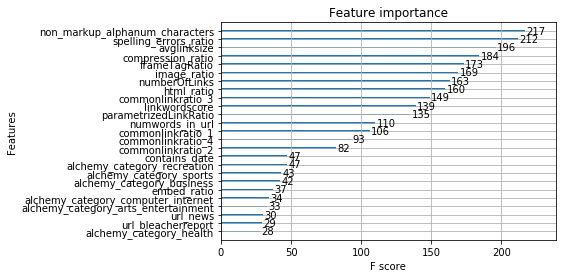

In [141]:
print(random_search_xgb.best_estimator_)

##Training Error
xgb_bestmdl_pred_trn = pd.Series(random_search_xgb.predict_proba(X_trn)[:,1],index = y_trn.index)
error_xgb_trn = pd.concat([y_trn,xgb_bestmdl_pred_trn],axis = 1)
error_xgb_trn = error_xgb_trn.rename(columns = {'label':'actual',0:'prediction'})
fpr, tpr, thresholds = metrics.roc_curve(error_xgb_trn.actual, error_xgb_trn.prediction, pos_label=1)
print(metrics.auc(fpr, tpr))

##Holdout Error
xgb_bestmdl_pred_hld = pd.Series(random_search_xgb.predict_proba(X_hld)[:,1],index = y_hld.index)
error_xgb_hld = pd.concat([y_hld,xgb_bestmdl_pred_hld],axis = 1)
error_xgb_hld = error_xgb_hld.rename(columns = {'label':'actual',0:'prediction'})
fpr, tpr, thresholds = metrics.roc_curve(error_xgb_hld.actual, error_xgb_hld.prediction, pos_label=1)
print(metrics.auc(fpr, tpr))

##Create Test
col_order = X_hld.columns.tolist()
clean_tst = clean_tst[col_order]
xgb_bestmdl_pred_tst = pd.Series(random_search_xgb.predict_proba(clean_tst)[:,1])
out_tst = pd.concat([raw_tst.urlid,xgb_bestmdl_pred_tst],axis = 1)
out_tst = out_tst.rename(columns = {'urlid':'urlid',0:"label"})
out_tst.to_csv('test_file_v4.csv',sep = ',')

plot_importance(random_search_xgb.best_estimator_,max_num_features = 25)

In [246]:
#### XGBOOST -- tracking results by parameter ####
warnings.simplefilter(action='ignore', category=FutureWarning)
xgb_cv = XGBClassifier(n_estimators = 250, objective = 'binary:logistic',rnadom_state = 123123)

min_chi_w = []
max_dep =  []
learning_rt =   []
colsamp_bylev = []
colsamp_bytre =  []
reg_alpha =  []
gridxgb_trn_error = []
gridxgb_hld_error = []
for i in range(1,5):
    min_chi_w.append(int(randint.rvs(3,6,size = 1)))
    max_dep.append(int(randint.rvs(2,6,size = 1))) 
    learning_rt.append(float(uniform.rvs(0.01,0.04,size = 1)))
    colsamp_bylev.append(float(uniform.rvs(0.75,0.2,size = 1)))
    colsamp_bytre.append(float(uniform.rvs(0.75,0.2,size = 1)))
    reg_alpha.append(float(uniform.rvs(0.001,0.02,size = 1)))
    
    param_xgb_search = {'min_child_weight':[min_chi_w[i-1]],
                        'max_depth': [max_dep[i-1]],
                        'learning_rate': [learning_rt[i-1]],
                        'colsample_bylevel': [colsamp_bylev[i-1]],
                        'colsample_bytree': [colsamp_bytre[i-1]],
                        'reg_alpha': [reg_alpha[i-1]]    
    }
    grid_search_xgb = GridSearchCV(xgb_cv,
                                          param_grid = param_xgb_search,
                                          cv = 5,
                                          scoring = 'roc_auc',
                                          refit = True)
    grid_search_xgb.fit(X_trn,y_trn, eval_metric = 'auc',
                          eval_set = [(X_hld,y_hld)],
                          early_stopping_rounds = 10,
                          verbose = 0)
    
    ##Training Error
    grid_xgb_bestmdl_pred_trn = pd.Series(grid_search_xgb.predict_proba(X_trn)[:,1],index = y_trn.index)
    error_gridxgb_trn = pd.concat([y_trn,grid_xgb_bestmdl_pred_trn],axis = 1)
    error_gridxgb_trn = error_gridxgb_trn.rename(columns = {'label':'actual',0:'prediction'})
    fpr, tpr, thresholds = metrics.roc_curve(error_gridxgb_trn.actual, error_gridxgb_trn.prediction, pos_label=1)
    gridxgb_trn_error.append(metrics.auc(fpr, tpr))
    #print(metrics.auc(fpr, tpr))

    ##Holdout Error
    grid_xgb_bestmdl_pred_hld = pd.Series(grid_search_xgb.predict_proba(X_hld)[:,1],index = y_hld.index)
    error_gridxgb_hld = pd.concat([y_hld,grid_xgb_bestmdl_pred_hld],axis = 1)
    error_gridxgb_hld = error_gridxgb_hld.rename(columns = {'label':'actual',0:'prediction'})
    fpr, tpr, thresholds = metrics.roc_curve(error_gridxgb_hld.actual, error_gridxgb_hld.prediction, pos_label=1)
    #print(metrics.auc(fpr, tpr))
    gridxgb_hld_error.append(metrics.auc(fpr, tpr))



0.8621349130565592
0.7833974330359765
0.7842415688282242
0.7619831594379275
0.8880701811892384
0.7843882961852648
0.832110962523197
0.7803661083688291


In [278]:
#    fig,axs = plt.subplots()
metrics = pd.concat([pd.Series(min_chi_w),
           pd.Series(max_dep),
           pd.Series(learning_rt),
           pd.Series(colsamp_bylev),
           pd.Series(colsamp_bytre),
           pd.Series(reg_alpha),
           pd.Series(gridxgb_trn_error),
           pd.Series(gridxgb_hld_error)
          ],axis = 1)
metrics = metrics.rename(columns = {0:'Min_Child_Wgt',
                          1:'Max_Depth',
                          2:'Learning_Rate',
                          3:'Col_Samp_bylev',
                          4:'Col_Samp_bytre',
                          5:'reg_alpha',
                          6:'trn_error',
                          7:'hld_error' })

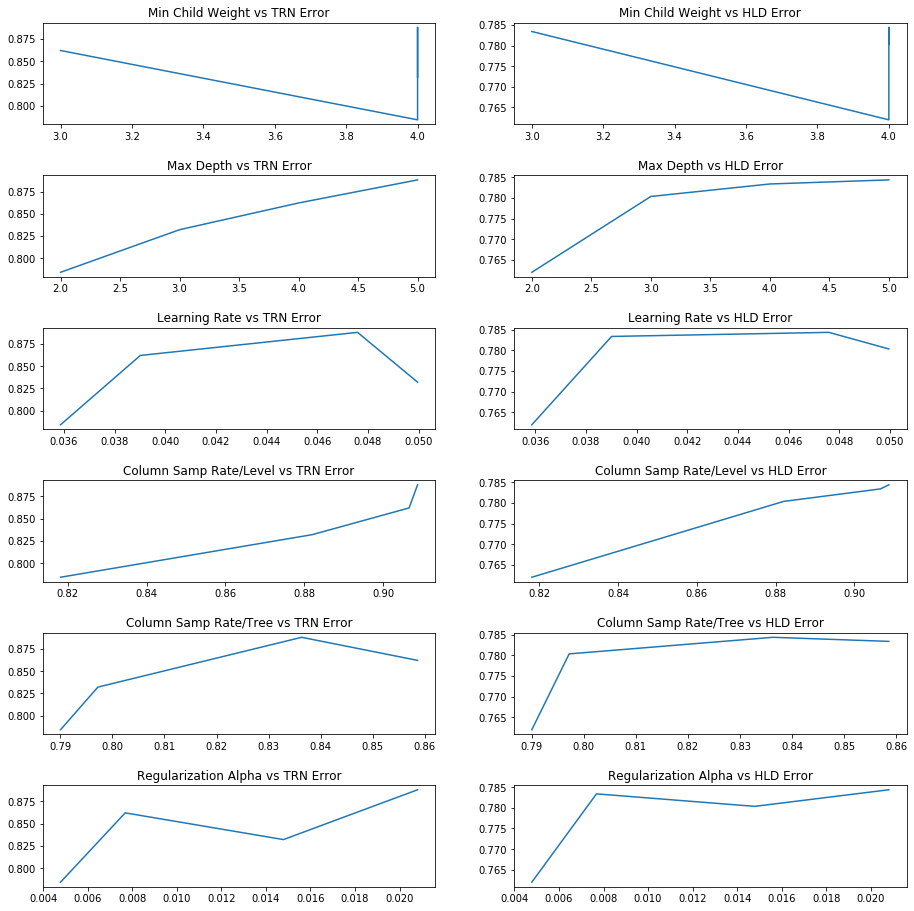

In [285]:
fig,axs=plt.subplots(6,2)
axs[0,0].plot(metrics.sort_values('Min_Child_Wgt').Min_Child_Wgt,metrics.sort_values('Min_Child_Wgt').trn_error)
axs[0,0].set_title('Min Child Weight vs TRN Error' )
axs[1,0].plot(metrics.sort_values('Max_Depth').Max_Depth,metrics.sort_values('Max_Depth').trn_error)
axs[1,0].set_title('Max Depth vs TRN Error' )
axs[2,0].plot(metrics.sort_values('Learning_Rate').Learning_Rate,metrics.sort_values('Learning_Rate').trn_error)
axs[2,0].set_title('Learning Rate vs TRN Error' )
axs[3,0].plot(metrics.sort_values('Col_Samp_bylev').Col_Samp_bylev,metrics.sort_values('Col_Samp_bylev').trn_error)
axs[3,0].set_title('Column Samp Rate/Level vs TRN Error' )
axs[4,0].plot(metrics.sort_values('Col_Samp_bytre').Col_Samp_bytre,metrics.sort_values('Col_Samp_bytre').trn_error)
axs[4,0].set_title('Column Samp Rate/Tree vs TRN Error' )
axs[5,0].plot(metrics.sort_values('reg_alpha').reg_alpha,metrics.sort_values('reg_alpha').trn_error)
axs[5,0].set_title('Regularization Alpha vs TRN Error' )


axs[0,1].plot(metrics.sort_values('Min_Child_Wgt').Min_Child_Wgt,metrics.sort_values('Min_Child_Wgt').hld_error)
axs[0,1].set_title('Min Child Weight vs HLD Error' )
axs[1,1].plot(metrics.sort_values('Max_Depth').Max_Depth,metrics.sort_values('Max_Depth').hld_error)
axs[1,1].set_title('Max Depth vs HLD Error' )
axs[2,1].plot(metrics.sort_values('Learning_Rate').Learning_Rate,metrics.sort_values('Learning_Rate').hld_error)
axs[2,1].set_title('Learning Rate vs HLD Error' )
axs[3,1].plot(metrics.sort_values('Col_Samp_bylev').Col_Samp_bylev,metrics.sort_values('Col_Samp_bylev').hld_error)
axs[3,1].set_title('Column Samp Rate/Level vs HLD Error' )
axs[4,1].plot(metrics.sort_values('Col_Samp_bytre').Col_Samp_bytre,metrics.sort_values('Col_Samp_bytre').hld_error)
axs[4,1].set_title('Column Samp Rate/Tree vs HLD Error' )
axs[5,1].plot(metrics.sort_values('reg_alpha').reg_alpha,metrics.sort_values('reg_alpha').hld_error)
axs[5,1].set_title('Regularization Alpha vs HLD Error' )

plt.subplots_adjust(bottom=0, left = 0,right=2, top=3,hspace = 0.5 )


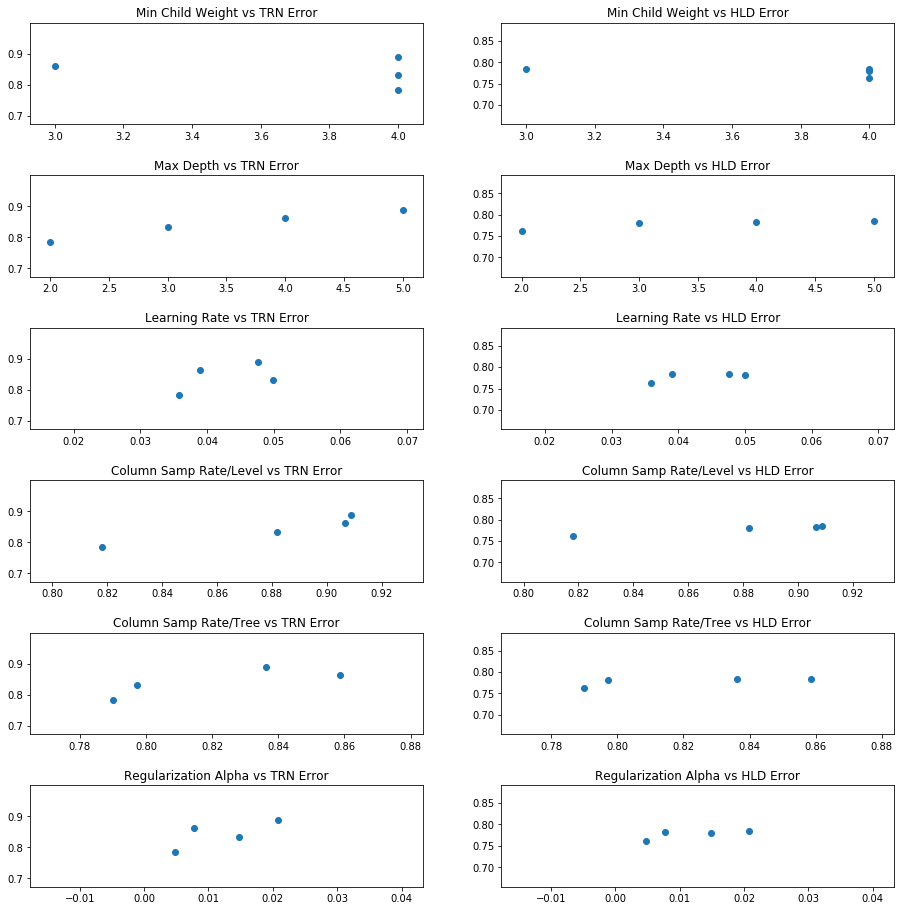

In [287]:
fig,axs=plt.subplots(6,2)
axs[0,0].scatter(metrics.Min_Child_Wgt,metrics.trn_error)
axs[0,0].set_title('Min Child Weight vs TRN Error' )
axs[1,0].scatter(metrics.Max_Depth,metrics.trn_error)
axs[1,0].set_title('Max Depth vs TRN Error' )
axs[2,0].scatter(metrics.Learning_Rate,metrics.trn_error)
axs[2,0].set_title('Learning Rate vs TRN Error' )
axs[3,0].scatter(metrics.Col_Samp_bylev,metrics.trn_error)
axs[3,0].set_title('Column Samp Rate/Level vs TRN Error' )
axs[4,0].scatter(metrics.Col_Samp_bytre,metrics.trn_error)
axs[4,0].set_title('Column Samp Rate/Tree vs TRN Error' )
axs[5,0].scatter(metrics.reg_alpha,metrics.trn_error)
axs[5,0].set_title('Regularization Alpha vs TRN Error' )


axs[0,1].scatter(metrics.Min_Child_Wgt,metrics.hld_error)
axs[0,1].set_title('Min Child Weight vs HLD Error' )
axs[1,1].scatter(metrics.Max_Depth,metrics.hld_error)
axs[1,1].set_title('Max Depth vs HLD Error' )
axs[2,1].scatter(metrics.Learning_Rate,metrics.hld_error)
axs[2,1].set_title('Learning Rate vs HLD Error' )
axs[3,1].scatter(metrics.Col_Samp_bylev,metrics.hld_error)
axs[3,1].set_title('Column Samp Rate/Level vs HLD Error' )
axs[4,1].scatter(metrics.Col_Samp_bytre,metrics.hld_error)
axs[4,1].set_title('Column Samp Rate/Tree vs HLD Error' )
axs[5,1].scatter(metrics.reg_alpha,metrics.hld_error)
axs[5,1].set_title('Regularization Alpha vs HLD Error' )

plt.subplots_adjust(bottom=0, left = 0,right=2, top=3,hspace = 0.5 )